In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import yaml
from yaml import Loader
from itertools import product
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
from velocileptors.LPT.cleft_fftw import CLEFT
from velocileptors.EPT.cleft_kexpanded_resummed_fftw import RKECLEFT
from scipy.signal import savgol_filter
from scipy.interpolate import splrep, splev
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import h5py as h5
import sys
sys.path.append('/global/homes/j/jderose/project/ZeNBu/')
from zenbu_rsd import Zenbu_RSD
from zenbu import Zenbu
from Utils.spherical_bessel_transform_fftw import SphericalBesselTransform
from Utils.qfuncfft import QFuncFFT
from Utils.loginterp import loginterp

plt.rcParams['figure.figsize']        = 10., 10.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 16
plt.rcParams['axes.titlesize']        = 16
plt.rcParams['legend.frameon']        = True
plt.rcParams['legend.fancybox']        = True
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 16
plt.rcParams['ytick.labelsize']       = 16
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = True
plt.rcParams['font.family']           = 'serif'
#plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 16


def _cleft_pk(k, p_lin, D=None, cleftobj=None, kecleft=True):
    '''
    Returns a spline object which computes the cleft component spectra.
    Computed either in "full" CLEFT or in "k-expanded" CLEFT (kecleft)
    which allows for faster redshift dependence.
    Args:
        k: array-like
            Array of wavevectors to compute power spectra at (in h/Mpc).
        p_lin: array-like
            Linear power spectrum to produce velocileptors predictions for.
            If kecleft==True, then should be for z=0, and redshift evolution is
            handled by passing the appropriate linear growth factor to D.
        D: float
            Linear growth factor. Only required if kecleft==True.
        kecleft: bool
            Whether to use kecleft or not. Setting kecleft==True
            allows for faster computation of spectra keeping cosmology
            fixed and varying redshift if the cleftobj from the
            previous calculation at the same cosmology is provided to
            the cleftobj keyword.
    Returns:
        cleft_aem : InterpolatedUnivariateSpline
            Spline that computes basis spectra as a function of k.
        cleftobt: CLEFT object
            CLEFT object used to compute basis spectra.
    '''

    if kecleft:
        if D is None:
            raise(ValueError('Must provide growth factor if using kecleft'))

        # If using kecleft, check if we're only varying the redshift

        if cleftobj is None:
            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, p_lin)

        # Adjust growth factors
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        cleftobj = CLEFT(k, p_lin, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, p_lin, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    cleftpk[3:, :] = cleftobj.pktable.T[3:, :]
    cleftpk[2, :] /= 2
    cleftpk[6, :] /= 0.25
    cleftpk[7, :] /= 2
    cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')#, kind='cubic')

    return cleftspline, cleftobj



def _lpt_pk(k, p_lin, f, cleftobj=None, kecleft=False, zenbu=True, 
            third_order=True, one_loop=True, cutoff=np.pi*700/525.,
            jn=15, N=2700, nmax=8, ngauss=3):
    '''
    Returns a spline object which computes the cleft component spectra.
    Computed either in "full" CLEFT or in "k-expanded" CLEFT (kecleft)
    which allows for faster redshift dependence.
    Args:
        k: array-like
            Array of wavevectors to compute power spectra at (in h/Mpc).
        p_lin: array-like
            Linear power spectrum to produce velocileptors predictions for.
            If kecleft==True, then should be for z=0, and redshift evolution is
            handled by passing the appropriate linear growth factor to D.
        D: float
            Linear growth factor. Only required if kecleft==True.
        kecleft: bool
            Whether to use kecleft or not. Setting kecleft==True
            allows for faster computation of spectra keeping cosmology
            fixed and varying redshift if the cleftobj from the
            previous calculation at the same cosmology is provided to
            the cleftobj keyword.
    Returns:
        cleft_aem : InterpolatedUnivariateSpline
            Spline that computes basis spectra as a function of k.
        cleftobt: CLEFT object
            CLEFT object used to compute basis spectra.
    '''
    
    if not zenbu:
        lpt = LPT_RSD(k, p_lin, kIR=0.2, cutoff=cutoff,
                              extrap_min=-4, extrap_max = 3,
                              threads=1, jn=jn, third_order=third_order,
                             one_loop=one_loop)
        lpt.make_pltable(f, kv=k, nmax=4, 
                         apar=1, aperp=1)
    else:
        lpt  = Zenbu_RSD(k, p_lin, jn=jn, N=N, cutoff=cutoff)
        lpt.make_pltable(f, kv=k, nmax=nmax, ngauss=ngauss)
        
    p0table = lpt.p0ktable
    p2table = lpt.p2ktable
    p4table = lpt.p4ktable
    
    if not zenbu:
        p0table[:, 1] /= 2
        p0table[:, 5] /= 0.25
        p0table[:, 6] /= 2
        p0table[:, 7] /= 2    
#    
        p2table[:,1] /= 2
        p2table[:,5] /= 0.25
        p2table[:,6] /= 2
        p2table[:,7] /= 2   
#    
        p4table[:,1] /= 2
        p4table[:,5] /= 0.25
        p4table[:,6] /= 2
        p4table[:,7] /= 2  
    
    pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
    pktable[:,0,:] = p0table
    pktable[:,1,:] = p2table
    pktable[:,2,:] = p4table

    pellspline = interp1d(k, pktable.T, fill_value='extrapolate')#, kind='cubic')
    p0spline = interp1d(k, p0table.T, fill_value='extrapolate')#, kind='cubic')
    p2spline = interp1d(k, p2table.T, fill_value='extrapolate')#, kind='cubic')
    p4spline = interp1d(k, p4table.T, fill_value='extrapolate')#, kind='cubic')


    return lpt, p0spline, p2spline, p4spline, pellspline 


def _realspace_lpt_pk(k, p_lin, D=None, cleftobj=None, kecleft=False, zenbu=True, cutoff=np.pi*700/525.):
    '''
    Returns a spline object which computes the cleft component spectra.
    Computed either in "full" CLEFT or in "k-expanded" CLEFT (kecleft)
    which allows for faster redshift dependence.
    Args:
        k: array-like
            Array of wavevectors to compute power spectra at (in h/Mpc).
        p_lin: array-like
            Linear power spectrum to produce velocileptors predictions for.
            If kecleft==True, then should be for z=0, and redshift evolution is
            handled by passing the appropriate linear growth factor to D.
        D: float
            Linear growth factor. Only required if kecleft==True.
        kecleft: bool
            Whether to use kecleft or not. Setting kecleft==True
            allows for faster computation of spectra keeping cosmology
            fixed and varying redshift if the cleftobj from the
            previous calculation at the same cosmology is provided to
            the cleftobj keyword.
    Returns:
        cleft_aem : InterpolatedUnivariateSpline
            Spline that computes basis spectra as a function of k.
        cleftobt: CLEFT object
            CLEFT object used to compute basis spectra.
    '''

    if kecleft:
        if D is None:
            raise(ValueError('Must provide growth factor if using kecleft'))

        # If using kecleft, check if we're only varying the redshift

        if cleftobj is None:
            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, p_lin)

        # Adjust growth factors
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T
        
    elif zenbu:
#        print(k.shape)
#        print(p_lin.shape)
        zobj = Zenbu(k, p_lin, cutoff=cutoff, N=3000, jn=15)
        zobj.make_ptable(kvec=k)
        cleftpk = zobj.pktable.T
        cleftobj = zobj
#        print(cleftpk.shape)
        

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        cleftobj = CLEFT(k, p_lin, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, p_lin, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    if not zenbu:
        cleftpk[2, :] /= 2
        cleftpk[6, :] /= 0.25
        cleftpk[7, :] /= 2
        cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')#, kind='cubic')

    return cleftspline, cleftobj#, cleftpk

def load_pk_from_dict(input_data, get_nmodes=False):
    
    try:
        pk_ij_list = np.load(input_data, allow_pickle=True)
    except:
        pk_ij_list = input_data
        
    nspec = len(pk_ij_list)
    keys = list(pk_ij_list[0].keys())
    k = pk_ij_list[0]['k']
    nk = k.shape[0]
    
    if 'mu' in keys:
        mu = pk_ij_list[0]['mu']  
        nmu = mu.shape[-1]
    else:
        nmu = 1
        mu = None
    
    if 'power_poles' in keys:
        npoles = pk_ij_list[0]['power_poles'].shape[0]
        has_poles = True
        pk_pole_array = np.zeros((nspec, npoles, nk))
        
    else:
        npoles = 1
        has_poles = False
        
    pk_wedge_array = np.zeros((nspec, nk, nmu))
        
    for i in range(nspec):
#        print(pk_ij_list[i]['shotnoise'])
        #power_wedges is always defined, even if only using 1d pk (then wedge is [0,1])
        pk_wedges = pk_ij_list[i]['power_wedges']
        pk_wedge_array[i,...] = pk_wedges.reshape(nk,-1)
        
        if has_poles:
            pk_poles = pk_ij_list[i]['power_poles']
            pk_pole_array[i,...] = pk_poles
            nmodes = pk_ij_list[i]['nmodes']
        
    if has_poles:
        if get_nmodes:
            return k, mu, pk_wedge_array, pk_pole_array, nmodes
        else:
            return k, mu, pk_wedge_array, pk_pole_array
            
    else:
        return k, mu, pk_wedge_array
    
def get_spectra_from_fields(fields1, fields2, neutrinos=True):
    spectra = []
    for i, fi in enumerate(fields1):
        for j, fj in enumerate(fields2):
            if (i<j) | (neutrinos & (i==1) & (j==0)): continue
            spectra.append((fi, fj))
                      
    return spectra

def combine_real_space_spectra(k, spectra, bias_params, cross=False, numerical_nabla=False):

    pkvec = np.zeros((14, spectra.shape[1]))
    if numerical_nabla:
        pkvec[...] = spectra[:14]
    else:
        pkvec[:10, ...] = spectra[:10]
        # IDs for the <nabla^2, X> ~ -k^2 <1, X> approximation.
        nabla_idx = [0, 1, 3, 6]

        # Higher derivative terms
        pkvec[10:, ...] = -k[np.newaxis, :]**2 * pkvec[nabla_idx, ...]

    b1, b2, bs, bk2, sn = bias_params
    if not cross:
        bterms = [1,
                  2*b1, b1**2,
                  b2, b2*b1, 0.25*b2**2,
                  2*bs, 2*bs*b1, bs*b2, bs**2,
                  2*bk2, 2*bk2*b1, bk2*b2, 2*bk2*bs]
    else:
        # hm correlations only have one kind of <1,delta_i> correlation
        bterms = [1,
                  b1, 0,
                  b2/2, 0, 0,
                  bs, 0, 0, 0,
                  bk2, 0, 0, 0]

    p = np.einsum('b, bk->k', bterms, pkvec)

    if not cross:
        p += sn

    return p    

def combine_rsd_spectra(k, spectra_poles, bias_params, ngauss=3):

    pkvec = np.zeros((17, spectra_poles.shape[1], spectra_poles.shape[2]))
    pkvec[:10, ...] = spectra_poles[:10,...]
      
    b1,b2,bs,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4 = bias_params
    bias_monomials = np.array([1, 2*b1, b1**2, b2, b1*b2, 0.25*b2**2, 2*bs, 2*b1*bs, b2*bs, bs**2, alpha0, alpha2, alpha4,alpha6,sn,sn2,sn4])
    
    nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
    nus_calc = nus[0:ngauss]
    nus = nus[0:ngauss]
    ws = ws[:ngauss]
    n_nu = ngauss
    leggauss = True
        
    L0 = np.polynomial.legendre.Legendre((1))(nus)
    L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
    L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)        
        
    pk_stoch = np.zeros((3, n_nu, spectra_poles.shape[2]))    
    
    pk_stoch[0,:,:] = 1
    pk_stoch[1,:,:] = k[np.newaxis,:]**2 * nus[:, np.newaxis]**2 
    pk_stoch[2,:,:] = k[np.newaxis,:]**4 * nus[:, np.newaxis]**4
    
    pkvec[14:,0,...] = 0.5 * np.sum((ws*L0)[np.newaxis,:ngauss,np.newaxis]*pk_stoch,axis=1)
    pkvec[14:,1,...] = 2.5 * np.sum((ws*L2)[np.newaxis,:ngauss,np.newaxis]*pk_stoch,axis=1)
    pkvec[14:,2,...] = 4.5 * np.sum((ws*L4)[np.newaxis,:ngauss,np.newaxis]*pk_stoch,axis=1) 
    
    p0 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,0,:], axis=0)
    p2 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,1,:], axis=0)
    p4 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,2,:], axis=0)
    

    return p0, p2, p4

def combine_rsd_cross_spectra(k, spectra_poles, bias_params, ngauss=3):

    pkvec = np.zeros((5, spectra_poles.shape[1], spectra_poles.shape[2]))
    pkvec[:5, ...] = spectra_poles[:5,...]
      
    b1,b2,bs,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4 = bias_params
    bias_monomials = np.array([1, b1, 0.5 * b2, bs, alpha0])
     
    p0 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,0,:], axis=0) #+ sn
    p2 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,1,:], axis=0) #+ sn2
    p4 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,2,:], axis=0) #+ sn4
    

    return p0, p2, p4

def combine_real_space_cross_spectra(k, spectra_poles, bias_params):

    pkvec = np.zeros((5, spectra_poles.shape[1]))
    pkvec[:5, ...] = spectra_poles[:5,...]

    b1,b2,bs,bk,sn = bias_params
    bias_monomials = np.array([1, b1, 0.5 * b2, bs, bk])

    pk = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,:], axis=0) + sn

    return pk


def combine_spectra(k, spectra, bias_params, rsd=False):
    
    if rsd:
        p0, p2, p4 = combine_rsd_spectra(k, spectra, bias_params)
        pk = np.stack([p0, p2, p4])
    else:
        pk = combine_real_space_spectra(k, spectra, bias_params)
        
    return pk

def combine_cross_spectra(k, spectra, bias_params, rsd=False):
    
    if rsd:
        p0, p2, p4 = combine_rsd_cross_spectra(k, spectra, bias_params)
        pk = np.stack([p0, p2, p4])
    else:
        pk = combine_real_space_cross_spectra(k, spectra, bias_params)
        
    return pk
                      

def multipole_cov(pell, ell):
    
    if ell==0:
        cov = 2 * pell[0,:]**2 + 2/5 * pell[1,:]**2 + 2/9 * pell[2,:]**2
        
    elif ell==2:
        cov = 2/5 * pell[0,:]**2 + 6/35 * pell[1,:]**2 + 3578/45045 * pell[2,:]**2 \
               + 8/35 * pell[0,:] * pell[1,:] + 8/35 * pell[0,:] * pell[2,:] + 48/385 * pell[1,:] * pell[2,:]

    elif ell==4:
        cov = 2/9 * pell[0,:]**2 + 3578/45045 * pell[1,:]**2 + 1058/17017 * pell[2,:]**2 \
               + 80/693 * pell[0,:] * pell[1,:] + 72/1001 * pell[0,:] * pell[2,:] + 80/1001 * pell[1,:] * pell[2,:]
        
    return cov

def deconvolve_window(poles, window_inv, npoles=3):

    nk_win = window_inv.shape[0]//npoles
    if len(poles.shape)>2:
        poles_deconv = np.zeros((poles.shape[0],npoles,nk_win))
        for i in range(poles.shape[0]):
            poles_d = np.hstack(poles[i,:,:nk_win])
            poles_d = np.dot(window_inv, poles_d).reshape(3,-1)
            poles_deconv[i,...] = poles_d
    else:
        poles_deconv = np.hstack(poles[:,:nk_win])
        poles_deconv = np.dot(window_inv, poles_deconv).reshape(3,-1)

    return poles_deconv

def compute_beta_and_reduce_variance_tt(k, pk_nn, pk_ij_zn, pk_ij_zz, pk_ij_zb, 
                                        bias_vec, window=None, kin=None, kout=None, 
                                        s_ell=[0.1, 10, 100], sg_window=21, rsd=False,
                                        k0=0.618, dk=0.167, deconv=False, beta1_k=0.05):
    
    fields_z = ['1', 'd', 'd2', 's', 'n2']
    fields_zenbu = ['1', 'd', 'd2', 's']
    
    if deconv & (window is not None):
        pk_nn = deconvolve_window(pk_nn, np.linalg.inv(window).T)
        pk_ij_zn = deconvolve_window(pk_ij_zn, np.linalg.inv(window).T)
        pk_ij_zz = deconvolve_window(pk_ij_zz, np.linalg.inv(window).T)
        k = np.copy(k)
        k = k[:len(window)//3]
        pk_ij_zb = np.copy(pk_ij_zb)
        pk_ij_zb = pk_ij_zb[...,:len(window)//3]
    
    component_spectra_zz = get_spectra_from_fields(fields_z, fields_z, neutrinos=False)
    pk_ij_zz_dict = dict(zip(component_spectra_zz, pk_ij_zz))
    nspec = len(bias_vec)

    if rsd:
        if len(bias_vec)<11:
            bias_vec = np.hstack([bias_vec, np.zeros(11-len(bias_vec))])
            
    else:
        if len(bias_vec)<6:
            bias_vec = np.hstack([bias_vec, np.zeros(6-len(bias_vec))])        
    
    # first element of bias vec should always be one, so don't pass this 
    # to our usual component spectra summation functions

    pk_zz = combine_spectra(k, pk_ij_zz, bias_vec[1:], rsd=rsd)
    if kin is not None:
        pk_zenbu = combine_spectra(kin, pk_ij_zb, bias_vec[1:], rsd=rsd)
    else:
        pk_zenbu = combine_spectra(k, pk_ij_zb, bias_vec[1:], rsd=rsd)
        
    pk_zn = combine_cross_spectra(k, pk_ij_zn, bias_vec[1:], rsd=rsd)

    if rsd:
        cov_zn = np.stack([multipole_cov(pk_zn, ell) for ell in [0,2,4]])
        var_zz = np.stack([multipole_cov(pk_zz, ell) for ell in [0,2,4]])
        var_nn = np.stack([multipole_cov(pk_nn, ell) for ell in [0,2,4]])
    else:
        cov_zn = 2 * pk_zn ** 2
        var_zz = 2 * pk_zz ** 2
        var_nn = 2 * pk_nn ** 2
    
    beta = cov_zn / var_zz
    beta_damp = 1/2 * (1 - np.tanh((k - k0)/dk)) * beta

    r_zt = cov_zn / np.sqrt(var_zz * var_nn)
    beta_damp = np.atleast_2d(beta_damp)
    beta_damp[beta_damp != beta_damp] = 0
    beta_damp[:,:k.searchsorted(beta1_k)] = 1
    
    r_zt = np.atleast_2d(r_zt)
    r_zt[r_zt != r_zt] = 0

    beta_smooth = np.zeros_like(beta_damp)
    beta_smooth_nohex = np.zeros_like(beta_damp)
    
    for i in range(beta_smooth.shape[0]):

        beta_smooth[i,:] = savgol_filter(beta_damp.T[:,i], sg_window, 3) #splev(k, betaspl)    
        if i!=2:
            beta_smooth_nohex[i,:] = savgol_filter(beta_damp.T[:,i], sg_window, 3)#splev(k, betaspl)  
        else:
            beta_smooth_nohex[i,:] = 1
            
    r_zt_smooth = np.zeros_like(r_zt)
    r_zt_smooth_nohex = np.zeros_like(r_zt)

    for i in range(r_zt.shape[0]):
        spl = splrep(k, r_zt.T[:,i], s=s_ell[i])
        r_zt_smooth[i,:] = splev(k, spl)  #savgol_filter(r_zt.T[:,i], sg_window, 3)#splev(k, spl)    
        if i<1:
            r_zt_smooth_nohex[i,:] = splev(k, spl)  #savgol_filter(r_zt.T[:,i], sg_window, 3)#splev(k, spl)  
        else:
            r_zt_smooth_nohex[i,:] = 1
            
    if (window is not None) & (not deconv):

        pk_zenbu = np.hstack(pk_zenbu)
        pk_zenbu = np.dot(window.T, pk_zenbu).reshape(3,-1)
    
    pk_nn_hat = pk_nn - beta_damp * (pk_zz - pk_zenbu)
    pk_nn_betasmooth = pk_nn - beta_smooth * (pk_zz - pk_zenbu)
    pk_nn_betasmooth_nohex = pk_nn - beta_smooth * (pk_zz - pk_zenbu)
    pk_nn_beta1 = pk_nn - (pk_zz - pk_zenbu)
        
    return pk_nn_hat, pk_nn_betasmooth, pk_nn_betasmooth_nohex, pk_nn_beta1, beta, beta_damp, beta_smooth, beta_smooth_nohex, pk_zz, pk_zenbu, r_zt, r_zt_smooth, r_zt_smooth_nohex, pk_zn

def lpt_spectra(k, z, anzu_config, kin, pin, pkclass=None, zenbu=True, kmin=1e-3):
    
    if pkclass==None:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)
        pkclass = Class()
        pkclass.set(cfg["Cosmology"])
        pkclass.compute()
    else:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)        
    kt = np.logspace(1e-3,1,200)
    cutoff = np.pi * cfg['nmesh_in'] / cfg['lbox']
    kidx = kin.searchsorted(kmin)

    Dthis = pkclass.scale_independent_growth_factor(z)
    Dic = pkclass.scale_independent_growth_factor(cfg['z_ic'])
    pk_lin = np.array([pkclass.pk_lin(ki, np.array([z])) * cfg['Cosmology']['h']**3 for ki in kt * cfg['Cosmology']['h']])
    pk_cb_lin = np.array([pkclass.pk_cb_lin(ki, np.array([z])) * cfg['Cosmology']['h']**3 for ki in kt * cfg['Cosmology']['h']])

    
    f = pkclass.scale_independent_growth_factor_f(z)

    lptobj, p0spline, p2spline, p4spline, pellspline = _lpt_pk(kin[kidx:], pin[kidx:]*(Dthis/Dic)**2, f, cutoff=cutoff, third_order=False, one_loop=False, zenbu=zenbu)
    pk_zenbu = pellspline(k)

    cleftobj, p0spline_m, p2spline_m, p4spline_m, pellspline_m = _lpt_pk(kt, pk_lin, f, zenbu=False)
    cleftobj, p0spline_cb, p2spline_cb, p4spline_cb, pellspline_cb = _lpt_pk(kt, pk_cb_lin, f, zenbu=False)

    pk_m_3lpt = pellspline_m(k)
    pk_cb_3lpt = pellspline_cb(k)
        
    return pk_zenbu[:11], pk_m_3lpt[:11], pk_cb_3lpt[:11], pkclass #pk_zenbu[:11], pk_3lpt[:11], pkclass

def zenbu_spectra(k, z, anzu_config, kin, pin, pkclass=None, zenbu=True, N=2700, jn=15, rsd=True, nmax=6, ngauss=6):
    
    if pkclass==None:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)
        pkclass = Class()
        pkclass.set(cfg["Cosmology"])
        pkclass.compute()
    else:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)        
        
    kt = np.logspace(-3,1,400)

    try:
        cutoff = cfg['surrogate_gaussian_cutoff']
        if (cutoff == True):
            cutoff = np.pi * cfg['nmesh_in'] / cfg['lbox']
        else:
            cutoff = float(cfg['surrogate_gaussian_cutoff'])
    except Exception as e:
        cutoff = np.pi * cfg['nmesh_in'] / cfg['lbox']
        
    Dthis = pkclass.scale_independent_growth_factor(z)
    Dic = pkclass.scale_independent_growth_factor(cfg['z_ic'])
    f = pkclass.scale_independent_growth_factor_f(z)
    
    if rsd:
        lptobj, p0spline, p2spline, p4spline, pspline = _lpt_pk(kin, pin*(Dthis/Dic)**2, 
                                                               f, cutoff=cutoff, 
                                                               third_order=False, one_loop=False,
                                                               zenbu=zenbu, jn=jn, N=N, nmax=nmax, ngauss=ngauss)
        pk_zenbu = pspline(k)
        
    else:
        pspline, _ = _realspace_lpt_pk(kin, pin*(Dthis/Dic)**2)  
        pk_zenbu = pspline(k)[1:]

    return pk_zenbu[:11]

def reduce_variance_tt(k, pk_nn, pk_ij_zn, pk_ij_zz, anzu_config, z, bias_vec, window=None,
                       kin=None, kout=None, s_ell=[0.1, 10, 100],
                       sg_window=21, rsd=True, neutrinos=True,
                       pkclass=None, pk_ij_zenbu=None, deconv=False):

    p_in = np.genfromtxt('{}/input_powerspec.txt'.format('/'.join(anzu_config.split('/')[:-1])))
    kth, p_m_lin = p_in[:,0], p_in[:,1]*(2*np.pi)**3 
    if pk_ij_zenbu is None:
        if kin is not None:
            pk_ij_zenbu = zenbu_spectra(kin, z, anzu_config, kth, p_m_lin, pkclass=pkclass, rsd=rsd)
        else:
            pk_ij_zenbu = zenbu_spectra(k, z, anzu_config, kth, p_m_lin, pkclass=pkclass, rsd=rsd)
            
    pk_nn_hat, pk_nn_betasmooth, pk_nn_betasmooth_nohex, pk_nn_beta1, beta, beta_damp, beta_smooth, beta_smooth_nohex, pk_zz, pk_zenbu, r_zt, r_zt_smooth, r_zt_smooth_nohex, pk_zn = compute_beta_and_reduce_variance_tt(k, pk_nn, pk_ij_zn, pk_ij_zz, pk_ij_zenbu, bias_vec, window=window, kin=kin, kout=kout, s_ell=s_ell, rsd=rsd, k0=0.618, dk=0.167, sg_window=sg_window, deconv=deconv)
    return pk_nn_hat, pk_nn_betasmooth, pk_nn_betasmooth_nohex, pk_nn_beta1, beta, beta_damp, beta_smooth, beta_smooth_nohex, pk_zz, pk_zenbu, r_zt, r_zt_smooth, r_zt_smooth_nohex, pk_zn, pk_ij_zenbu, pkclass



In [2]:
def measure_2pt_bias_rsd(k, pk_ij_heft, pk_tt, kmax, ellmax=2, nbias=3):
    
    kidx = k.searchsorted(kmax)
    kcut = k[:kidx]
    pk_tt_kcut = pk_tt[:ellmax,:kidx]
    pk_ij_heft_kcut = pk_ij_heft[:,:,:kidx]
    bvec0 = [1, 0, 0]#, 0, 0]
    
    loss = lambda bvec : np.sum((pk_tt_kcut - combine_spectra(kcut, pk_ij_heft_kcut, np.hstack([bvec,np.zeros(10-len(bvec))]), rsd=True)[:ellmax,:])**2/(2 * pk_tt_kcut**2))
    #b1,b2,bs,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4
    
    out = minimize(loss, bvec0)
    
    return out

def measure_2pt_bias(k, pk_ij_heft, pk_tt, kmax, nbias=3):
    
    kidx = k.searchsorted(kmax)
    kcut = k[:kidx]
    pk_tt_kcut = pk_tt[:kidx]
    pk_ij_heft_kcut = pk_ij_heft[:,:kidx]
    bvec0 = [1, 0, 0, 0, 5000]

    loss = lambda bvec : np.sum((pk_tt_kcut - combine_spectra(kcut, pk_ij_heft_kcut, np.hstack([bvec,np.zeros(5-len(bvec))])))**2/(2 * pk_tt_kcut**2))
    #b1,b2,bs,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4
    
    out = minimize(loss, bvec0)
    
    return out


In [5]:
boxnum = 76
a_this = 0.6504
massbin = 0
basename = '/global/cfs/projectdirs/cosmosim/slac/jderose/aemulus_nu/Box{}_1400/anzu_fields_2xsmooth/'.format(boxnum)
#nbasename = '/global/cfs/projectdirs/cosmosim/slac/jderose/aemulus_nu/Box{}_1400/anzu_fields/'.format(boxnum)
configbase = '/global/cfs/projectdirs/cosmosim/slac/jderose/aemulus_nu_setup/Box{}_1400/run/'.format(boxnum)

anzu_config = configbase + 'anzu_fields.param'
with open(anzu_config, 'r') as fp:
    cfg = yaml.load(fp, Loader=Loader)
pk_tt_fname = basename + 'outbgc2_10_massbin_{}.h5_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(massbin, a_this)
pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
pk_zt_fname = basename + 'zcv_cross_outbgc2_10_massbin_{}.h5_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(massbin, a_this)
pk_nn_fname = basename + 'basis_spectra_nbody_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
pk_zn_fname = basename + 'basis_spectra_za_surrogate_crosscorr_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)

pk_tt_rs_fname = basename + 'outbgc2_10_massbin_{}.h5_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(massbin, a_this)
pk_zz_rs_fname = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
pk_zt_rs_fname = basename + 'zcv_cross_outbgc2_10_massbin_{}.h5_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(massbin, a_this)
pk_nn_rs_fname = basename + 'basis_spectra_nbody_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
pk_zn_rs_fname = basename + 'basis_spectra_za_surrogate_crosscorr_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)

m=0

z_this = 1/a_this - 1
k, mu, _, pk_tt_poles = load_pk_from_dict(pk_tt_fname)
k, mu, _, pk_ij_nn_poles = load_pk_from_dict(pk_nn_fname)
k, mu, _, pk_ij_zn_poles = load_pk_from_dict(pk_zn_fname)

k, mu, _, pk_ij_zz_poles = load_pk_from_dict(pk_zz_fname)
k, mu, _, pk_ij_zt_poles = load_pk_from_dict(pk_zt_fname)

k, mu, pk_tt, _ = load_pk_from_dict(pk_tt_rs_fname)
k, mu, pk_ij_zz, _ = load_pk_from_dict(pk_zz_rs_fname)
k, mu, pk_ij_zt, _ = load_pk_from_dict(pk_zt_rs_fname)
k, mu, pk_ij_nn, _ = load_pk_from_dict(pk_nn_rs_fname)
k, mu, pk_ij_zn, _ = load_pk_from_dict(pk_zn_rs_fname)


p_in = np.genfromtxt('{}/input_powerspec.txt'.format('/'.join(anzu_config.split('/')[:-1])))
kth, p_m_lin = p_in[:,0], p_in[:,1]*(2*np.pi)**3 

#pk_zb, pk_3lpt, pk_3lpt_cb, pkclass = lpt_spectra(k, z_this, anzu_config, kth, p_m_lin, pkclass=None)

In [6]:
bvec_opt = measure_2pt_bias_rsd(k, pk_ij_zz_poles[:,:,:], pk_tt_poles[0,:,:], 0.15, ellmax=1)
bvec_opt_rs = measure_2pt_bias(k, pk_ij_zz[:,:,0], pk_tt[0,:,0], 0.15)

In [7]:
print(bvec_opt['x'])
print(bvec_opt_rs['x'])
#print(b_full)

[ 1.12434234  3.02656682 -2.52808984]
[ 1.07034208e+00  6.99307833e-01 -3.67906490e-01 -1.45682139e-01
  5.00000088e+03]


In [8]:
window = np.loadtxt('window_nmesh350.npy')
kin = np.loadtxt('kin_window_nmesh350.npy')
kout = np.loadtxt('kout_window_nmesh350.npy')

In [ ]:
i=2
bias_vec = [1, *bvec_opt_rs['x'][:i]]
pk_nn_hat, pk_nn_betasmooth, pk_nn_betasmooth_nohex,\
pk_nn_beta1, beta, beta_damp, beta_smooth, \
beta_smooth_nohex, pk_zz, pk_zenbu, r_zt, r_zt_smooth,\
r_zt_smooth_nohex, pk_zn, pk_ij_zenbu_poles, pkclass = reduce_variance_tt(k,  pk_tt_poles[0,...], pk_ij_zt_poles,\
                                                                          pk_ij_zz_poles, anzu_config, z_this,\
                                                                          bias_vec, rsd=True, window=window, kin=kin)#, pk_ij_zenbu=pk_ij_zenbu_poles)


In [152]:
pktable = np.zeros((p0table.shape[-1], 3, p0table.shape[0]))
pktable[:,0,:] = p0table.T
pktable[:,1,:] = p2table.T
pktable[:,2,:] = p4table.T
pktable[pktable!=pktable] = 0
pk_zb_conv = np.stack([np.dot(window, pktable[i,:,:].reshape(-1)).reshape(3,-1) for i in range(3)])

In [164]:
pktable = pspline_2xs(kin)
pk_zb_conv = np.stack([np.dot(window, pktable[i,:,:].reshape(-1)).reshape(3,-1) for i in range(3)])

In [138]:
nmesh = 1400
lbox = 1050
ngauss = 6

nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
pknutable = lptobj_2xs.pknutable

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

        
p0table = lptobj_2xs.p0ktable
p2table = lptobj_2xs.p2ktable
p4table = lptobj_2xs.p4ktable
p6table = 6.5 * np.sum((ws*L6)[:,None,None]*pknutable,axis=0)



pell_convs = []
nmesh_win = 350
pell_conv_list = []
kout = np.linspace(0, nmesh * np.pi / lbox, int(nmesh // 2))

for i in range(3):
    pell_in = [p0table[:,i], p2table[:,i], p4table[:,i], p6table[:,i]]
    pell_conv_i, norm_out, idx_o, keff = conv_theory_window_function(nmesh_win, lbox, kout, pell_in, kth)
    pell_conv_list.append(pell_conv_i.reshape(3,-1))
    
pell_conv = np.stack(pell_conv_list)    

In [139]:
pell_ij_poles_deconv = np.stack([deconvolve_window(pell_ij_poles[i,...], np.linalg.inv(window_sq).T) for i in range(3)])


0.7003513925859579
12.242567183242073
0.9588210165084183
1.3009583192553182
0.5705352541603909
1.7545389772485975


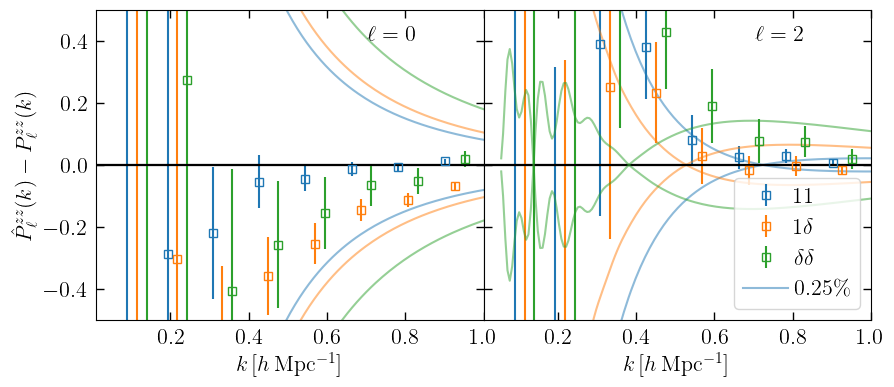

In [183]:
sidx = 0
ell = 2

ncut = 160
rebin = 20
nstart = 0

kb = np.sum(keff[nstart:ncut+nstart].reshape(-1,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
dkb = 0.025

f, ax = plt.subplots(1,2, sharex=True, sharey=True)
lines = []
for ell in range(2):
    for sidx in range(3):
        rebin_list = []
        ptc = np.sum(pell_conv[sidx,ell,nstart:ncut+nstart].reshape(ncut//rebin,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)

        for i in range(len(pell_ij_poles_list)):
            di = np.sum(pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart].reshape(ncut//rebin,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            rebin_list.append(di-ptc)

        pm_std = np.std(np.stack(rebin_list), axis=0) / np.sqrt(len(rebin_list))

        pm = np.sum(pell_ij_poles[sidx,ell,nstart:ncut+nstart].reshape(ncut//rebin,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        pt = np.sum(pk_zenbu_2xs[sidx,ell,nstart:ncut+nstart].reshape(ncut//rebin,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
#        delta = np.sum(((pell_ij_poles[sidx,ell,nstart:ncut+nstart] - pk_zb_conv[sidx,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]).reshape(-1, rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1, rebin), axis=-1)
        delta = np.sum(((pell_ij_poles[sidx,ell,nstart:ncut+nstart] - pell_conv[sidx,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]).reshape(-1, rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1, rebin), axis=-1)

        l = ax[ell].errorbar(kb + dkb * sidx, delta, pm_std, c='C{}'.format(sidx), marker='s', ls='', markerfacecolor="None",)
#        l = ax[ell].errorbar(kb + dkb * sidx, delta, pm_std, c='C{}'.format(sidx), marker='s', ls='')
        
        ax[ell].hlines(0, k[0], k[-1], color='k')
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pspline_2xs(k)[sidx,ell,:], color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pspline_2xs(k)[sidx,ell,:], color='C{}'.format(sidx), alpha=0.5)    
        ax[ell].set_xlabel(r'$k\, [h\,\rm Mpc^{-1}]$')
        if sidx==0:
            ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)        
        
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
        print(np.sum((delta/pm_std)**2)/len(delta))

lines.append(ll[0])
ax[1].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='lower right')
ax[0].set_ylabel(r'$\hat{P}^{zz}_{\ell}(k) - P^{zz}_{\ell}(k)$')
ax[0].set_xlim([0.01,1])
ax[0].set_ylim([-0.5, 0.5])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))
f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
plt.savefig('zenbu_comp_2xsmooth_nohex.pdf', dpi=100, bbox_inches='tight')

In [156]:
pk_zb_conv.shape

(3, 3, 699)

In [157]:
pell_conv.shape

(3, 3, 699)

(-1.0, 1.0)

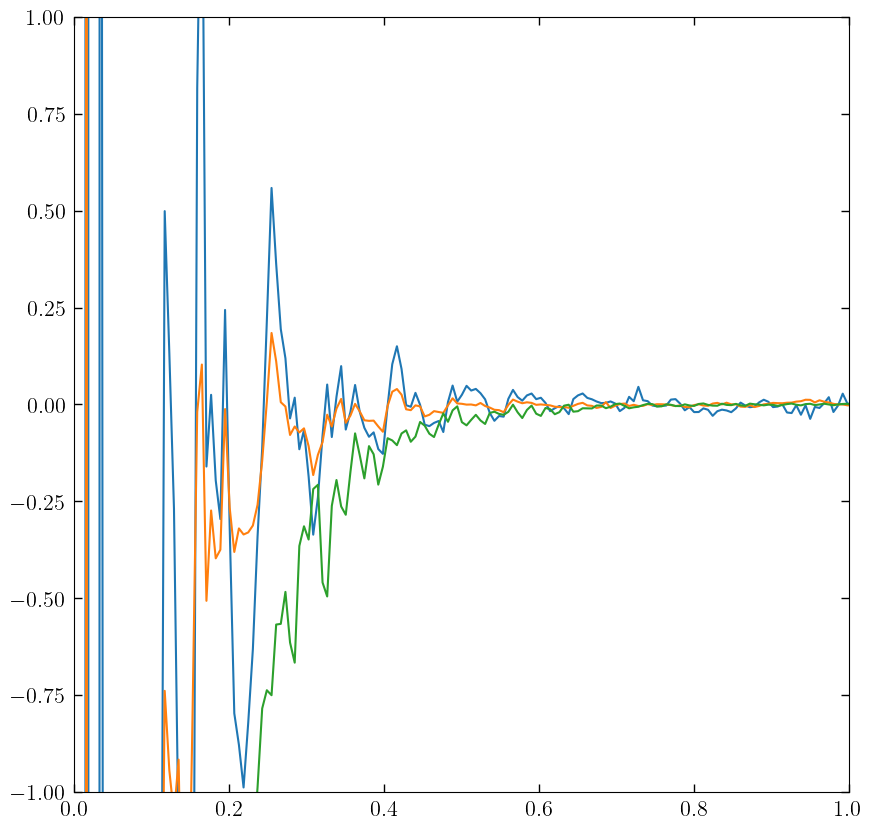

In [172]:
plt.plot(k, pk_zb_conv[1,:,:].T-pell_conv[1,:,:].T)
plt.xlim([0,1])
plt.ylim([-1,1])

#plt.gca().set_prop_cycle(None)
#plt.plot(k, k[:,np.newaxis] * pell_conv[0,:,:].T, ls='--')

0.7003513925859579
12.242567183242073
0.9588210165084183
1.3009583192553182
0.5705352541603909
1.7545389772485975


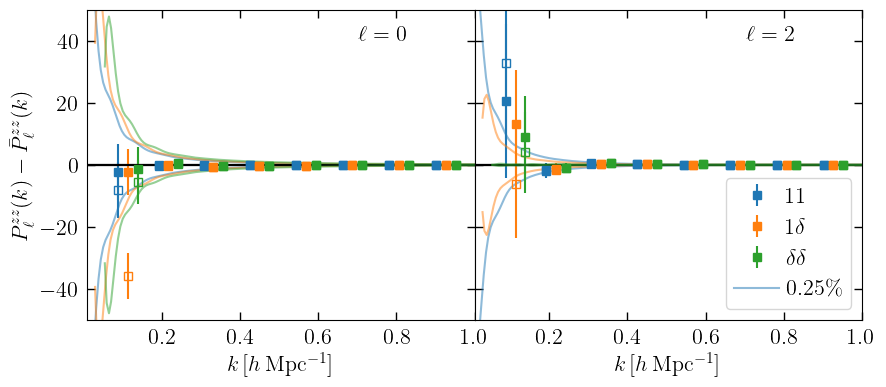

In [181]:
sidx = 0
ell = 2

ncut = 160
rebin = 20
nstart = 0

kb = np.sum(keff[nstart:ncut+nstart].reshape(-1,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
dkb = 0.025

f, ax = plt.subplots(1,2, sharex=True, sharey=True)
lines = []
for ell in range(2):
    for sidx in range(3):
        rebin_list = []
        ptc = np.sum(pell_conv[sidx,ell,nstart:ncut+nstart].reshape(ncut//rebin,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)

        for i in range(len(pell_ij_poles_list)):
            di = np.sum(pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart].reshape(ncut//rebin,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            rebin_list.append(di-ptc)

        pm_std = np.std(np.stack(rebin_list), axis=0) / np.sqrt(len(rebin_list))

        pm = np.sum(pell_ij_poles[sidx,ell,nstart:ncut+nstart].reshape(ncut//rebin,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        pt = np.sum(pk_zenbu_2xs[sidx,ell,nstart:ncut+nstart].reshape(ncut//rebin,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        delta = np.sum(((pell_ij_poles_deconv[sidx,ell,nstart:ncut+nstart] - pk_zenbu_2xs[sidx,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]).reshape(-1, rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1, rebin), axis=-1)
#        delta = np.sum(((pell_ij_poles[sidx,ell,nstart:ncut+nstart] - pell_conv[sidx,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]).reshape(-1, rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1, rebin), axis=-1)

        l = ax[ell].errorbar(kb + dkb * sidx, delta, pm_std, c='C{}'.format(sidx), marker='s', ls='', markerfacecolor="None",)
        delta = np.sum(((pell_ij_poles[sidx,ell,nstart:ncut+nstart] - pell_conv[sidx,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]).reshape(-1, rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1, rebin), axis=-1)

        l = ax[ell].errorbar(kb + dkb * sidx, delta, pm_std, c='C{}'.format(sidx), marker='s', ls='')
        
        ax[ell].hlines(0, k[0], k[-1], color='k')
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pspline_2xs(k)[sidx,ell,:], color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pspline_2xs(k)[sidx,ell,:], color='C{}'.format(sidx), alpha=0.5)    
        ax[ell].set_xlabel(r'$k\, [h\,\rm Mpc^{-1}]$')
        if sidx==0:
            ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)        
        
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
        print(np.sum((delta/pm_std)**2)/len(delta))

lines.append(ll[0])
ax[1].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='lower right')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
ax[0].set_xlim([0.01,1])
ax[0].set_ylim([-50, 50])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))
f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth_nohex.pdf', dpi=100, bbox_inches='tight')

In [433]:
kt = kth

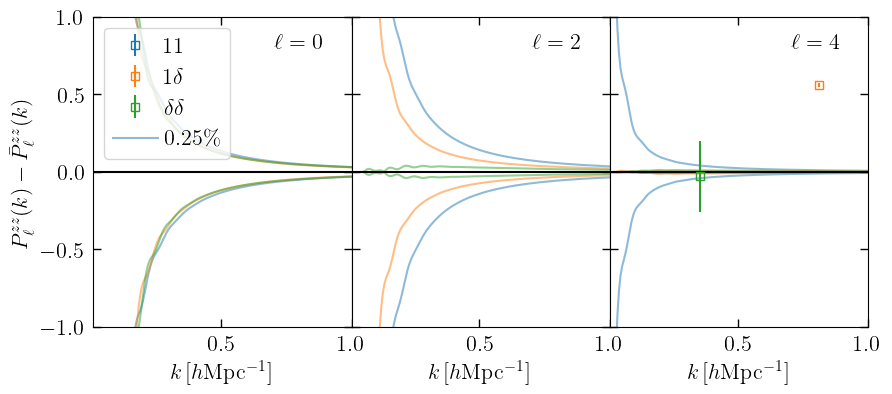

In [434]:
kd = k
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline(kin).T

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 1
kcut = np.mean(kd[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
dkstd = kcut[1:] - kcut[:-1]
pell_ij_fine = pspline(kcut)
var = np.stack([4 * np.pi**2 / (kcut**2 * dkstd[0] * V) * np.stack([multipole_cov(pell_ij_fine[i,:,:], ell) for ell in [0,2,4]]) for i in range(3)])
dkb=0.025
lines = []
for ell in range(3):
    for sidx in range(3):
        fudge=1
        idx = pktable.T[sidx,ell,:]==pktable.T[sidx,ell,:]
        pspline_kc1 = interp1d(kt[idx], pktable.T[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu = pspline_kc1(keff)
        
        dlist = []
        for i in range(len(pell_ij_poles_list)):
            delta_i = (pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu[nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(ncut//rebin,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/np.sum(kd[:ncut].reshape(-1,rebin)**3, axis=-1)
#        delta_std = np.sqrt(var[sidx,ell,:])/9
        
        delta = (pell_ij_poles_deconv[sidx,ell,nstart:ncut+nstart]-pk_zenbu[nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-1, 1])
ax[1].set_ylim([-1, 1])
ax[2].set_ylim([-1, 1])
f.set_figheight(4)
f.subplots_adjust(wspace=0)

#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


In [311]:
from numba import jit

rank = 0
size = 1

@jit(nopython=True)
def meshgrid(x, y, z):
    xx = np.empty(shape=(y.size, x.size, z.size), dtype=x.dtype)
    yy = np.empty(shape=(y.size, x.size, z.size), dtype=y.dtype)
    zz = np.empty(shape=(y.size, x.size, z.size), dtype=z.dtype)
    for i in range(y.size):
        for j in range(x.size):
            for k in range(z.size):
                xx[i,j,k] = x[i]  # change to x[k] if indexing xy
                yy[i,j,k] = y[j]  # change to y[j] if indexing xy
                zz[i,j,k] = z[k]  # change to z[i] if indexing xy
    return zz, yy, xx

@jit(nopython=True)
def periodic_window_function(nmesh, lbox, kout, kin=None, k2weight=True):
    
    kvals = np.zeros(nmesh, dtype=np.float32)
    kvals[:nmesh//2] = np.arange(0, 2 * np.pi * nmesh / lbox / 2, 2 * np.pi / lbox, dtype=np.float32)
    kvals[nmesh//2:] = np.arange(-2 * np.pi * nmesh / lbox / 2, 0, 2 * np.pi / lbox, dtype=np.float32)

    kvalsmpi = kvals[rank * nmesh // size : (rank + 1) * nmesh // size]
    kvalsr = np.arange(0, 2 * np.pi * nmesh / lbox / 2, 2 * np.pi / lbox, dtype=np.float32) 
    kx, ky, kz = meshgrid(kvalsmpi, kvals, kvalsr)    
    knorm = np.sqrt(kx**2 + ky**2 + kz**2)
    mu = kz / knorm
    mu[0,0,0] = 0
    
    ellmax = 3
    
    if kin is None:
        kin = kout
        nkin = len(kin) - 1
    else:
        nkin = len(kin)
        
    if k2weight:
        dk = np.zeros_like(kin)
        dk[:-1] = kin[1:] - kin[:-1]
        dk[-1] = dk[-2]
    
    nkout = len(kout) - 1
    dkin = (kin[1:] - kin[:-1])[0]
    
    idx_o = np.digitize(knorm, kout) - 1
    nmodes_out = np.zeros(nkout * 3)

    idx_i = np.digitize(kin, kout) - 1
    nmodes_in = np.zeros(nkout, dtype=np.float32)

    for i in range(len(kout)):
        idx = i==idx_i
        if k2weight:
            nmodes_in[i] = np.sum(kin[idx]**2 * dk[idx])
        else:
            nmodes_in[i] = np.sum(idx)
            
    norm_in = 1/nmodes_in
    norm_in[nmodes_in==0] = 0
    norm_in_allell = np.zeros(3 * len(norm_in))
    norm_in_allell[:nkout] = norm_in
    norm_in_allell[nkout:2*nkout] = norm_in
    norm_in_allell[2*nkout:3*nkout] = norm_in
    
    window = np.zeros((nkout * 3, nkin * 3), dtype=np.float32)
    keff = np.zeros(nkout, dtype=np.float32)
    
    L0 = np.ones_like(mu, dtype=np.float32)
    L2 = (3 * mu**2 - 1) / 2
    L4 = (35 * mu**4 - 30 * mu**2 + 3) / 8
        
    legs = [L0, L2, L4]
    pref = [1, (2 * 2 + 1), (2 * 4 + 1)]
    
    for i in range(kx.shape[0]):
        for j in range(kx.shape[1]):
            for k in range(kx.shape[2]):
                if (idx_o[i,j,k]>=nkout): 
                    pass
                else:
                    if k==0:
                        nmodes_out[idx_o[i,j,k]::nkout] += 1
                        keff[idx_o[i,j,k]] += knorm[i,j,k]
                    else:
                        nmodes_out[idx_o[i,j,k]::nkout] += 2
                        keff[idx_o[i,j,k]] += 2 * knorm[i,j,k]

                    for beta in range(nkin):
                        if k2weight:
                            w = kin[beta]**2 * dk[beta]
                        else:
                            w = 1
                        if (idx_i[beta] == idx_o[i,j,k]):               
                            for ell in range(ellmax):
                                for ellp in range(ellmax):
    #                                window[ell * nkout + idx_o[i,j,k], ellp * nkin + beta] += legs[ell][i,j,k] * legs[ellp][i,j,k] * kin[beta]**3 * norm_in[idx_o[i,j,k]] * norm_out[idx_o[i,j,k]]
                                    if k!=0:
                                        window[int(ell * nkout) + int(idx_o[i,j,k]), int(ellp * nkin) + int(beta)] += 2 * pref[ell] * legs[ell][i,j,k] * legs[ellp][i,j,k] * w # * norm_in[idx_o[i,j,k]]
                                    else:
                                        window[int(ell * nkout) + int(idx_o[i,j,k]), int(ellp * nkin) + int(beta)] += pref[ell] * legs[ell][i,j,k] * legs[ellp][i,j,k] * w # * norm_in[idx_o[i,j,k]]

    norm_out = 1/nmodes_out
    norm_out[nmodes_out==0] = 0
    window = window * norm_out.reshape(-1, 1) * norm_in_allell.reshape(-1, 1)
    keff = keff * norm_out[:nkout]
    
    return window, norm_out, norm_in, idx_o, idx_i, knorm, legs, keff

@jit(nopython=True)
def cov_window(nmesh, lbox, kout, p0th, p2th, p4th, kth):
    
    kvals = np.zeros(nmesh, dtype=np.float64)
    kvals[:nmesh//2] = np.arange(0, 2 * np.pi * nmesh / lbox / 2, 2 * np.pi / lbox, dtype=np.float64)
    kvals[nmesh//2:] = np.arange(-2 * np.pi * nmesh / lbox / 2, 0, 2 * np.pi / lbox, dtype=np.float64)

    kvalsmpi = kvals[rank * nmesh // size : (rank + 1) * nmesh // size]
    kvalsr = np.arange(0, 2 * np.pi * nmesh / lbox / 2, 2 * np.pi / lbox, dtype=np.float64) 
    kx, ky, kz = meshgrid(kvalsmpi, kvals, kvalsr)    
    knorm = np.sqrt(kx**2 + ky**2 + kz**2)
    mu = kz / knorm
    mu[0,0,0] = 0
    
    p0 = np.interp(knorm, kth, p0th)
    p2 = np.interp(knorm, kth, p2th)
    p4 = np.interp(knorm, kth, p4th)
    p0[0,0,0] = 0
    p2[0,0,0] = 0
    p4[0,0,0] = 0
        
    ellmax = 3
    
    nkout = len(kout) - 1
    idx_o = np.digitize(knorm, kout) - 1
    nmodes_out = np.zeros(nkout * 3, dtype=np.float64)
 
    cov = np.zeros((nkout * 3, nkout * 3), dtype=np.float64)

    L0 = np.ones_like(mu, dtype=np.float64)
    L2 = (3 * mu**2 - 1) / 2
    L4 = (35 * mu**4 - 30 * mu**2 + 3) / 8
    pk = (p0 * L0 + p2 * L2 + p4 * L4)**2
        
    legs = [L0, L2, L4]
    pref = [1, (2 * 2 + 1), (2 * 4 + 1)]
    
    for i in range(kx.shape[0]):
        for j in range(kx.shape[1]):
            for k in range(kx.shape[2]):
                if (idx_o[i,j,k]>nkout): 
                    pass
                else:
                    if k==0:
                        nmodes_out[idx_o[i,j,k]::nkout] += 1
                    else:
                        nmodes_out[idx_o[i,j,k]::nkout] += 2
                    for ell in range(ellmax):
                        for ellp in range(ellmax):
                            if k!=0:
                                cov[int(ell * nkout) + int(idx_o[i,j,k]), int(ellp * nkout) + int(idx_o[i,j,k])] += 2 * pref[ell] * pref[ellp] * legs[ell][i,j,k] * legs[ellp][i,j,k] * pk[i,j,k] # * norm_in[idx_o[i,j,k]]
                            else:
                                cov[int(ell * nkout) + int(idx_o[i,j,k]), int(ellp * nkout) + int(idx_o[i,j,k])] += pref[ell] * pref[ellp] * legs[ell][i,j,k] * legs[ellp][i,j,k] * pk[i,j,k] # * norm_in[idx_o[i,j,k]]

    nmodes_out = np.outer(nmodes_out, nmodes_out)
    norm_out = 1/nmodes_out
#    norm_out[nmodes_out==0] = 0
    cov = cov * norm_out
    
    return cov, norm_out, idx_o

@jit(nopython=True)
def conv_theory_window_function(nmesh, lbox, kout, plist, kth):
    
    kvals = np.zeros(nmesh, dtype=np.float32)
    kvals[:nmesh//2] = np.arange(0, 2 * np.pi * nmesh / lbox / 2, 2 * np.pi / lbox, dtype=np.float32)
    kvals[nmesh//2:] = np.arange(-2 * np.pi * nmesh / lbox / 2, 0, 2 * np.pi / lbox, dtype=np.float32)
    kvalsr = np.arange(0, 2 * np.pi * nmesh / lbox / 2, 2 * np.pi / lbox, dtype=np.float32) 
    kz, ky, kx = meshgrid(kvals, kvals, kvalsr)    
    knorm = np.sqrt(kx**2 + ky**2 + kz**2)
    mu = kz / knorm
    mu[0,0,0] = 0
    
    ellmax = 3
    
    nkout = len(kout) - 1
    idx_o = np.digitize(knorm, kout) - 1
    nmodes_out = np.zeros(nkout * 3)
  
    pell_conv = np.zeros((nkout * 3), dtype=np.float32)
    keff = np.zeros(nkout, dtype=np.float32)
    
    ellmax_in = len(plist)

    pells = []
    for i in range(ellmax_in):
        pells.append(np.interp(knorm, kth, plist[i]))
        pells[i][0,0,0] = 0
        
#    p0 = np.interp(knorm, kth, p0th)
#    p2 = np.interp(knorm, kth, p2th)
#    p4 = np.interp(knorm, kth, p4th)
        
    L0 = np.ones_like(mu, dtype=np.float32)
    L2 = (3 * mu**2 - 1) / 2
    L4 = (35 * mu**4 - 30 * mu**2 + 3) / 8
    L6 = (231 * mu**6 - 315 * mu**4 + 105 * mu**2 - 5) / 16
    
#    pk = (p0 * L0 + p2 * L2 + p4 * L4)

    legs = [L0, L2, L4, L6]
    pref = [(2 * (2 * i) + 1) for i in range(ellmax_in)]
#    pells = [p0, p2, p4]
    for i in range(kx.shape[0]):
        for j in range(kx.shape[1]):
            for k in range(kx.shape[2]):
                if (idx_o[i,j,k]>=nkout): 
                    pass
                else:
                    if k==0:
                        nmodes_out[idx_o[i,j,k]::nkout] += 1
                        keff[idx_o[i,j,k]] += knorm[i,j,k]
                    else:
                        nmodes_out[idx_o[i,j,k]::nkout] += 2
                        keff[idx_o[i,j,k]] += 2 * knorm[i,j,k]      
                    for ell in range(ellmax):
                        for ellp in range(ellmax_in):
                            if k!=0:
                                pell_conv[int(ell * nkout) + int(idx_o[i,j,k])] += 2 * pref[ell] * legs[ell][i,j,k] * legs[ellp][i,j,k] * pells[ellp][i,j,k]
                            else:
                                pell_conv[int(ell * nkout) + int(idx_o[i,j,k])] += pref[ell] * legs[ell][i,j,k] * legs[ellp][i,j,k] * pells[ellp][i,j,k]

    norm_out = 1/nmodes_out
    norm_out[nmodes_out==0] = 0
    pell_conv = pell_conv * norm_out
    keff = keff * norm_out[:nkout]
    
    return pell_conv, norm_out, idx_o, keff


In [36]:
kt = np.logspace(-3,1,10000)
nmesh = 350
nmesh_fid = 1400
lbox = 1050
kout = np.linspace(0, nmesh_fid * np.pi / lbox, int(nmesh_fid // 2))
nko = len(kout)-1
#kin = np.arange(0.0001, 1.1, 0.0001)
kin = kt[:kt.searchsorted(1.01)]
window, norm_out, norm_in, idx_o, idx_i, knorm, legs, keff = periodic_window_function(nmesh, lbox, kout, kin=kin, k2weight=True)

In [384]:
pknutable.shape

(48, 1228, 19)

In [414]:
kt = kth#np.logspace(-3,1,10000)

ngauss = 24
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
pknutable = lptobj.pknutable

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

        
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable
p6table = 6.5 * np.sum((ws*L6)[:,None,None]*pknutable,axis=0)

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table


pell_convs = []

for i in range(3):
    pell_in = [p0table[:,i], p2table[:,i], p4table[:,i], p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs.append(pell_conv.reshape(3,-1))
    

In [415]:
pell_convs = np.stack(pell_convs)

(0.0, 1.0)

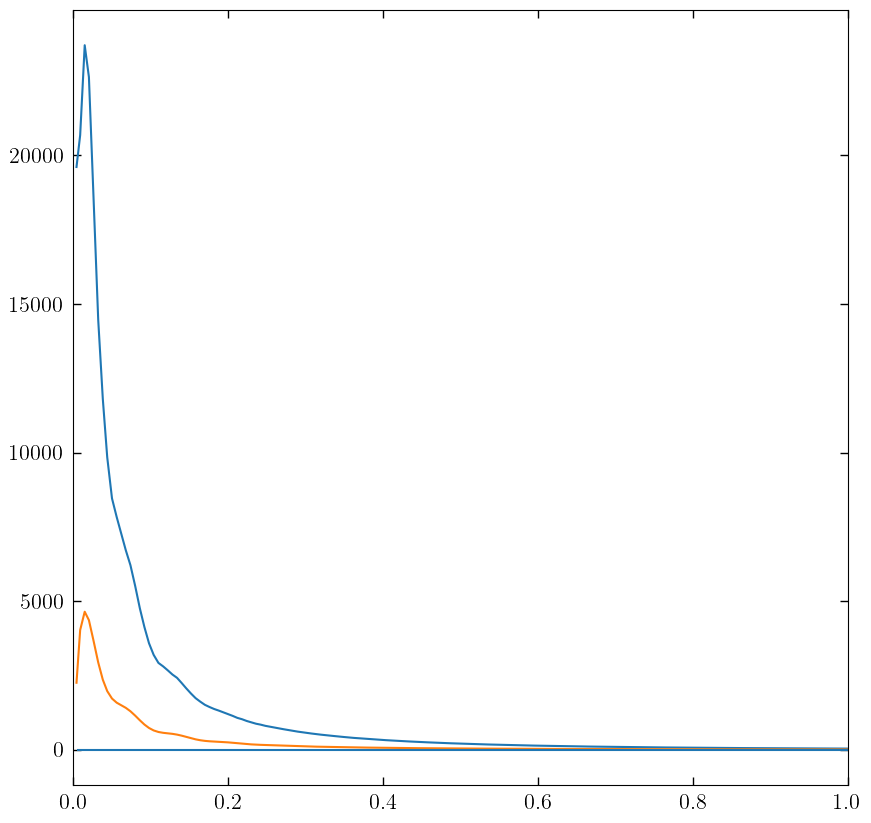

In [422]:
sidx=1
ell=0
#plt.semilogx(k, pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:])
for ell in range(1):
    plt.plot(k, pell_ij_poles[sidx,ell,:])
    plt.plot(k, (pell_convs[sidx,ell,:]))
#plt.semilogx(k, pell_ij_poles[sidx,ell,:])
plt.hlines(0, k[0], k[-1])
#plt.ylim([-1,1])
plt.xlim([0,1])

(0.0, 1.0)

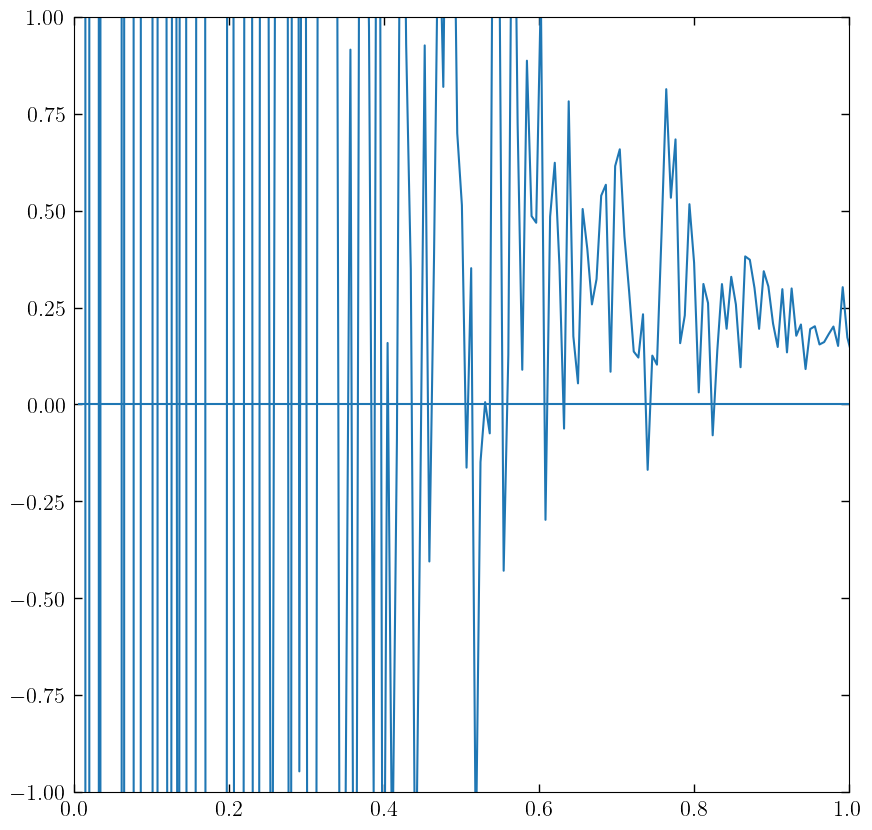

In [385]:
sidx=1
ell=0
#plt.semilogx(k, pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:])
for ell in range(2,3):
#    plt.plot(k, pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:])
    plt.plot(k, (pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:]))
#plt.semilogx(k, pell_ij_poles[sidx,ell,:])
plt.hlines(0, k[0], k[-1])
plt.ylim([-1,1])
plt.xlim([0,1])

(0.0, 1.0)

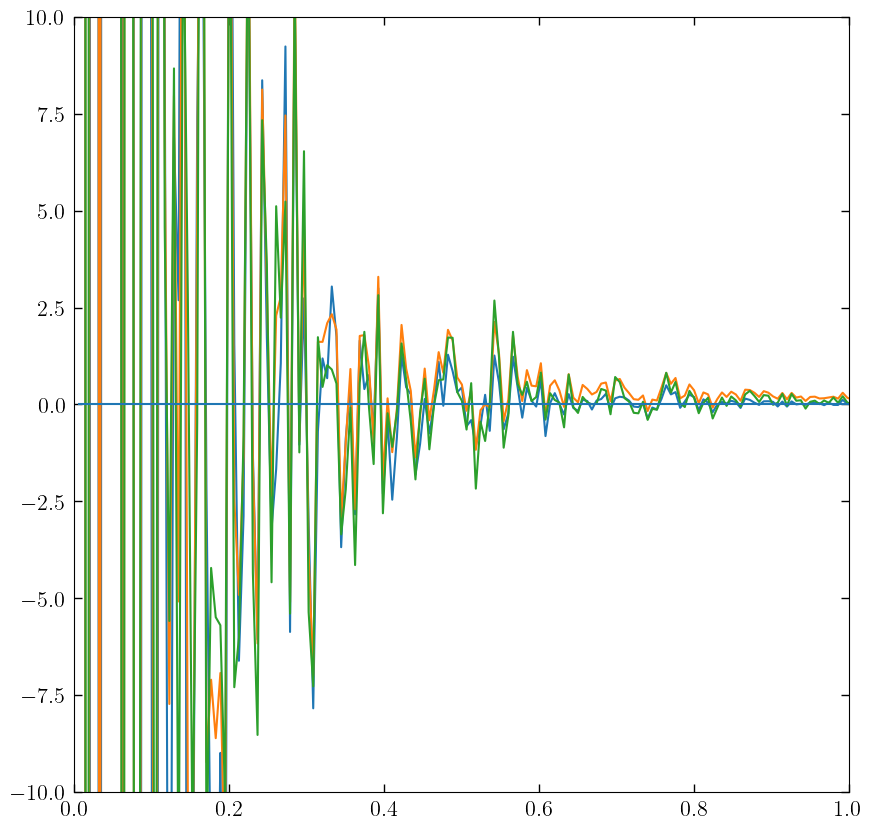

In [397]:
sidx=0
ell=2
#plt.semilogx(k, pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:])
for ell in range(2,3):
#    plt.plot(k, pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:])
    plt.plot(k, (pell_ij_poles[:3,ell,:]-pell_convs[:3,ell,:]).T)
#plt.semilogx(k, pell_ij_poles[sidx,ell,:])
plt.hlines(0, k[0], k[-1])
plt.ylim([-10,10])
plt.xlim([0,1])

In [332]:
covs = []
for i in range(3):
    cov, norm_out, idx_o = cov_window(nmesh, lbox, kout[::20], pktable[:,0,0], pktable[:,1,0], pktable[:,2,0], kth)
    cov[norm_out!=norm_out] = 0
    covs.append(cov)

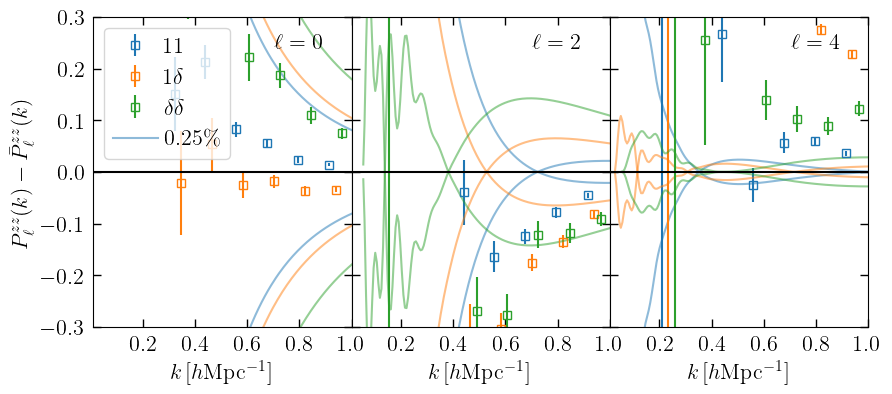

In [391]:
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline(kin) #* kin**2
#pk_zb_conv = np.stack([np.dot(window, pktable[i,:,:nki].reshape(-1)).reshape(3,-1) for i in range(3)])
#pk_zb_eval = pspline((kout[1:] + kout[:-1])/2)
#nmodes[:nko]*norm_out[0*nko:1*nko]

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 2
V = 1050**3
kcut = np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin) * kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025
lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):
        fudge=1
        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu_uc = pspline_kc1(k)
        #pk_zenbu = pell_convs[sidx,ell,nstart:ncut+nstart]

        pk_zenbu = pspline(k)[sidx,ell,nstart:ncut+nstart]
        dlist = []
        for i in range(len(pell_ij_poles_list)):
            delta_i = (pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]#* kd[nstart:ncut+nstart]**3
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        #delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
        delta = (pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-0.3, 0.3])
#ax[1].set_ylim([-1, 1])
#ax[2].set_ylim([-1, 1])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))

f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


In [345]:
len(deltas[i])

16

In [347]:
cut=4
for i in range(len(deltas)-1,len(deltas)):
    print(np.sum(deltas[i][:cut]**2 / delta_stds[i][:cut]**2)/ len(deltas[i][:cut]))

4.865176159635454


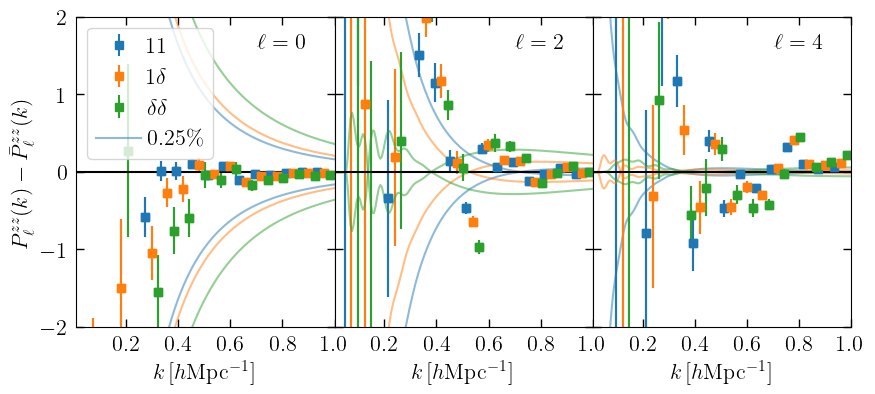

In [318]:
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline(kin) #* kin**2
#pk_zb_conv = np.stack([np.dot(window, pktable[i,:,:nki].reshape(-1)).reshape(3,-1) for i in range(3)])
#pk_zb_eval = pspline((kout[1:] + kout[:-1])/2)
#nmodes[:nko]*norm_out[0*nko:1*nko]

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 10
nstart = 0
V = 1050**3
kcut = np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin) * kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025
lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):
        fudge=1
        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu_uc = pspline_kc1(k)
        pk_zenbu = pell_convs[sidx,ell,nstart:ncut+nstart]
        
        dlist = []
        for i in range(len(pell_ij_poles_list)):
            delta_i = (pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]#* kd[nstart:ncut+nstart]**3
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        #delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
        delta = (pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pell_ij_poles_2[sidx,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
#        delta = (pell_ij_poles_2[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
#        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
       
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', color='C{}'.format(sidx))
        
        l2 = ax[ell].plot(k+dkb*sidx, -0.005*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.005*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-2, 2])
#ax[1].set_ylim([-1, 1])
#ax[2].set_ylim([-1, 1])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))

f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


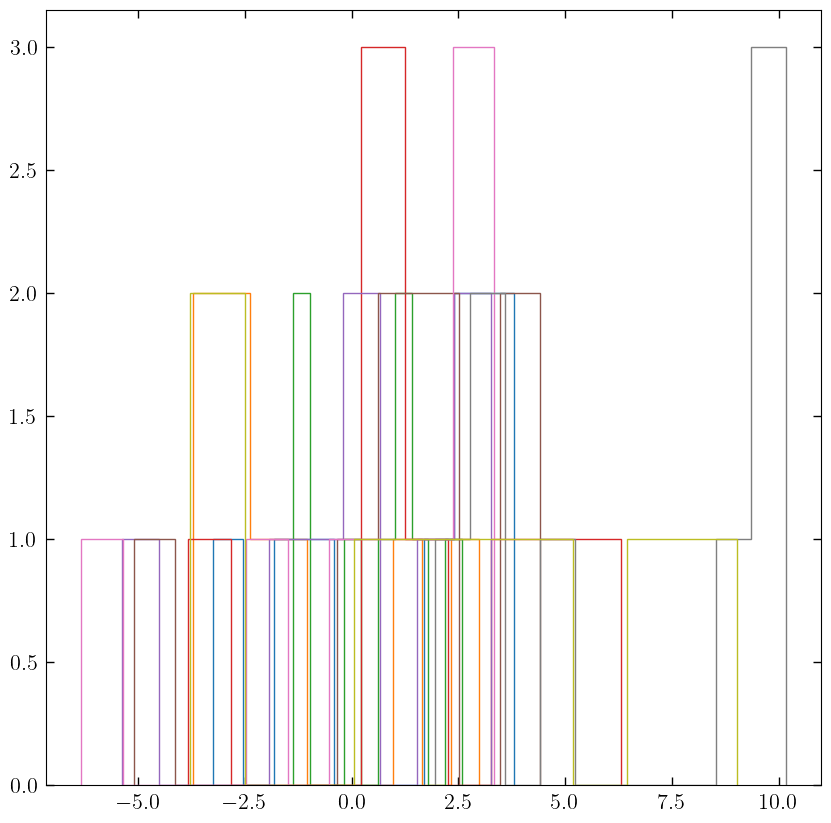

In [309]:
for i in range(len(deltas)):
    plt.hist((deltas[i] / delta_stds[i]), histtype='step')
    

In [63]:
nki = len(kin)

In [64]:
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline(kin) #* kin**2
pk_zb_conv = np.stack([np.dot(window, pktable[i,:,:nki].reshape(-1)).reshape(3,-1) for i in range(3)])
pk_zb_eval = pspline((kout[1:] + kout[:-1])/2)
#nmodes[:nko]*norm_out[0*nko:1*nko]

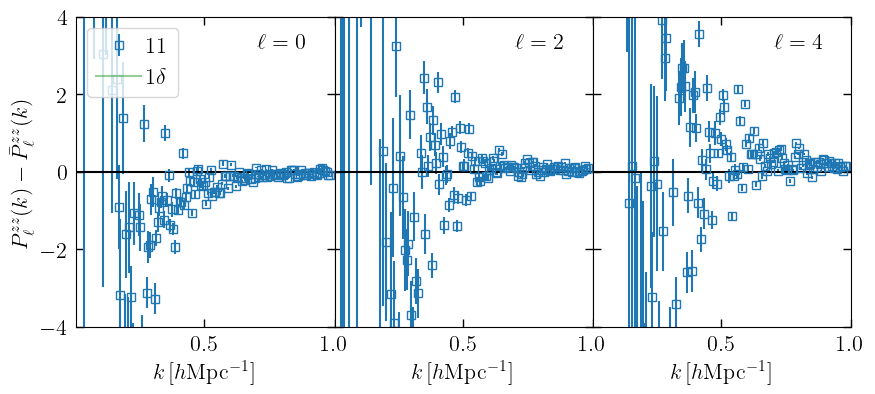

In [69]:
f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 0
kcut = k[nstart:ncut+nstart]
dkb=0.025
lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(1,2):
        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu_uc = pspline_kc1(k)
        pk_zenbu = pk_zb_conv[sidx,ell,nstart:ncut+nstart]
        
        dlist = []
        for i in range(len(pell_ij_poles_list)):
            delta_i = (pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
#        delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
    
        delta = (pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zenbu)
        deltas.append(delta)
        
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
#        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
#        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-4, 4])
ax[1].set_ylim([-4, 4])
ax[2].set_ylim([-4, 4])
f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


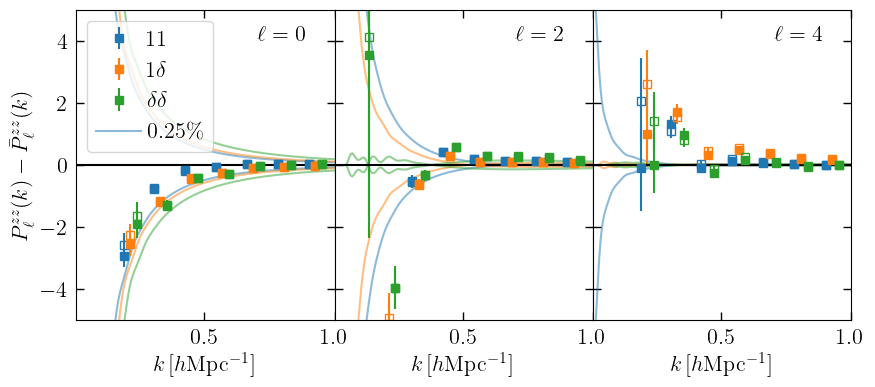

In [74]:
f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 0
kcut = np.sum(k[nstart:ncut+nstart].reshape(-1,rebin) * nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
dkb=0.025
lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):
        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu_uc = pspline_kc1(keff) 
        pk_zenbu = pk_zb_conv[sidx,ell,nstart:ncut+nstart]
        
        dlist = []
        for i in range(len(pell_ij_poles_list)):
            delta_i = (pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
            delta_i = np.sum(delta_i[:].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
#        delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
    
        delta = (pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)

        delta = (pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zenbu_uc[nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)        
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', color='C{}'.format(sidx))
        
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-5, 5])
ax[1].set_ylim([-5, 5])
ax[2].set_ylim([-5, 5])
f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


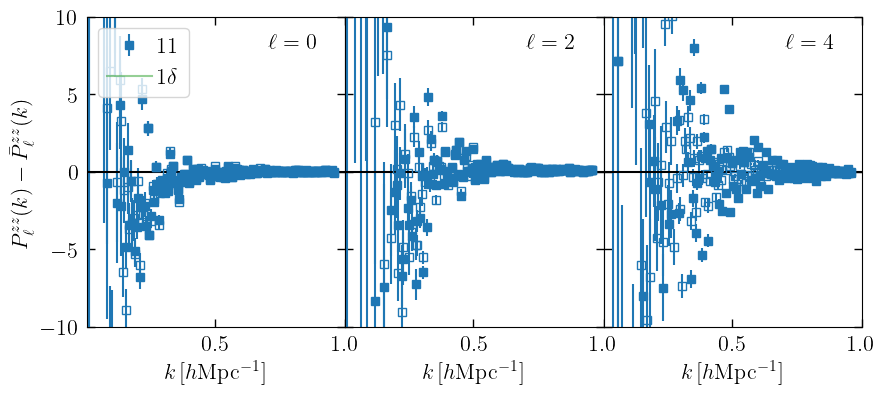

In [79]:
f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 0
kcut = k[nstart:ncut+nstart]
dkb=0.025
lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(1):
        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu_uc = pspline_kc1(keff)
        pk_zenbu = pk_zb_conv[sidx,ell,nstart:ncut+nstart]
        
        dlist = []
        for i in range(len(pell_ij_poles_list)):
            delta_i = (pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
#        delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
    
        delta = (pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zenbu)
        deltas.append(delta)
        
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        delta = (pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zenbu_uc[nstart:ncut+nstart])
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', color='C{}'.format(sidx))
        
#        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
#        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-10, 10])
ax[1].set_ylim([-10, 10])
ax[2].set_ylim([-10, 10])
f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


In [56]:
covs_ub = []

p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

for i in range(3):
    cov, norm_out, idx_o = cov_window(nmesh, lbox, kout, pktable[:,0,0], pktable[:,1,0], pktable[:,2,0], kt)
    cov[norm_out!=norm_out] = 0    
    covs_ub.append(cov)

In [75]:
nkout = len(kout) -1

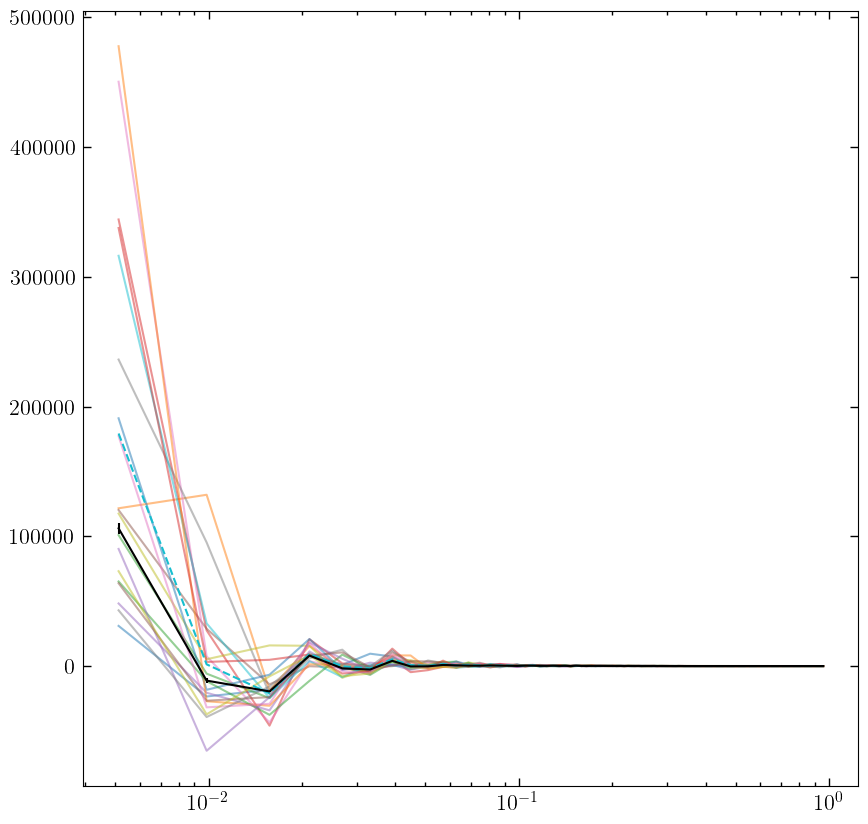

In [145]:
sidx=0
ell=2
for i in range(len(pell_ij_poles_list)):
    plt.semilogx(k[nstart:ncut+nstart], pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart], alpha=0.5)
plt.errorbar(k[nstart:ncut+nstart], pk_zb_conv[sidx,ell,nstart:ncut+nstart], np.sqrt(np.diag(covs_ub[sidx])[ell*nkout:][nstart:ncut+nstart])/len(pell_ij_poles_list), color='k')
plt.semilogx(k[nstart:ncut+nstart], pell_ij_poles[sidx,ell,nstart:ncut+nstart], ls='--')


(-1.0, 1.0)

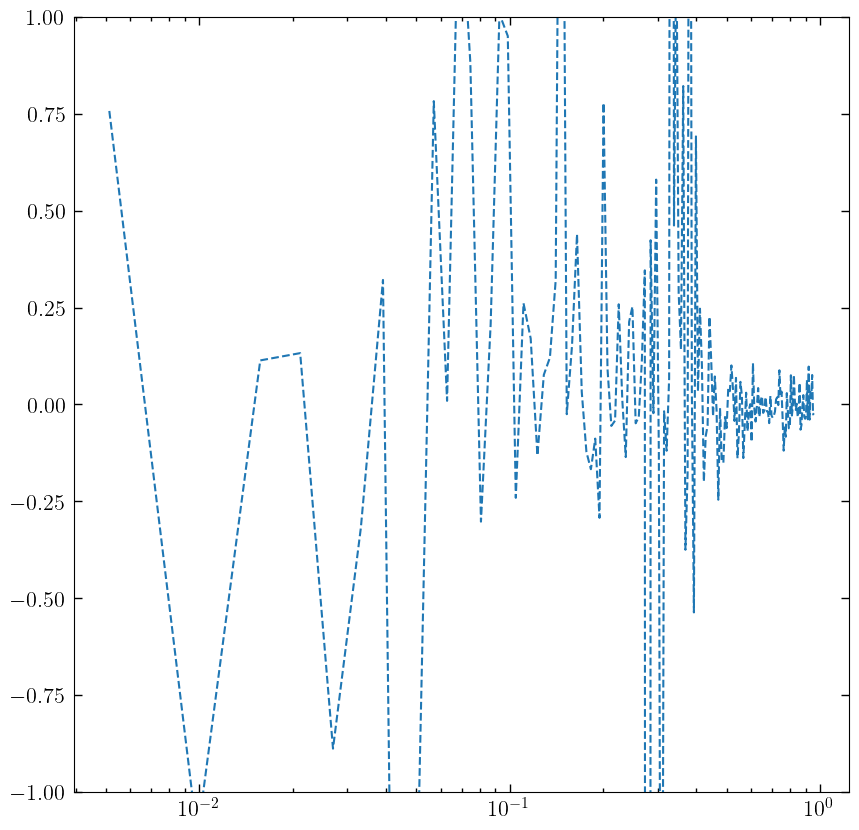

In [196]:
sidx=0
ell=2
#for i in range(len(pell_ij_poles_list)):
#    plt.semilogx(k[nstart:ncut+nstart], pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zb_conv[sidx,ell,nstart:ncut+nstart], alpha=0.5)
#plt.errorbar(k[nstart:ncut+nstart], np.zeros_like(pk_zb_conv[sidx,ell,nstart:ncut+nstart]), np.sqrt(np.diag(covs_ub[sidx])[ell*nkout:][nstart:ncut+nstart])/len(pell_ij_poles_list), color='k')
#plt.errorbar(k[nstart:ncut+nstart], np.zeros_like(pk_zb_conv[sidx,ell,nstart:ncut+nstart]), np.sqrt(np.diag(covs_ub[sidx])[ell*nkout:][nstart:ncut+nstart]), color='r')
plt.semilogx(k[nstart:ncut+nstart], k[nstart:ncut+nstart]**2*pell_ij_poles[sidx,ell,nstart:ncut+nstart]/pk_zb_conv[sidx,ell,nstart:ncut+nstart]-1, ls='--')
plt.ylim([-1,1])


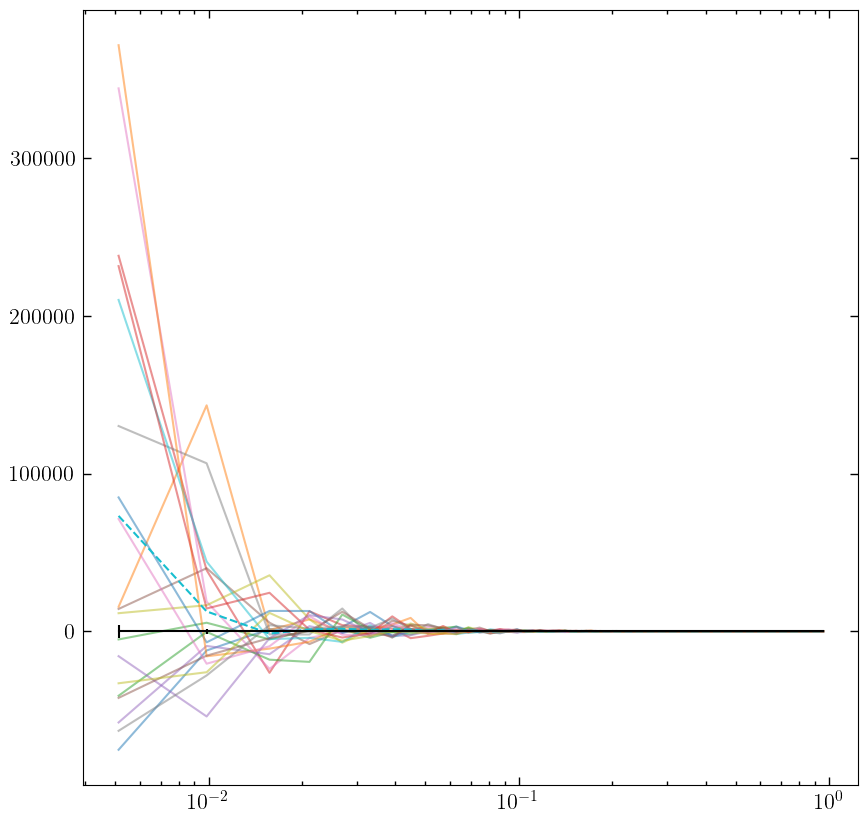

In [147]:
sidx=0
ell=2
for i in range(len(pell_ij_poles_list)):
    plt.semilogx(k[nstart:ncut+nstart], pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zb_conv[sidx,ell,nstart:ncut+nstart], alpha=0.5)
plt.errorbar(k[nstart:ncut+nstart], np.zeros_like(pk_zb_conv[sidx,ell,nstart:ncut+nstart]), np.sqrt(np.diag(covs_ub[sidx])[ell*nkout:][nstart:ncut+nstart])/len(pell_ij_poles_list), color='k')
#plt.errorbar(k[nstart:ncut+nstart], np.zeros_like(pk_zb_conv[sidx,ell,nstart:ncut+nstart]), np.sqrt(np.diag(covs_ub[sidx])[ell*nkout:][nstart:ncut+nstart]), color='r')
plt.semilogx(k[nstart:ncut+nstart], pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zb_conv[sidx,ell,nstart:ncut+nstart], ls='--')



<ErrorbarContainer object of 3 artists>

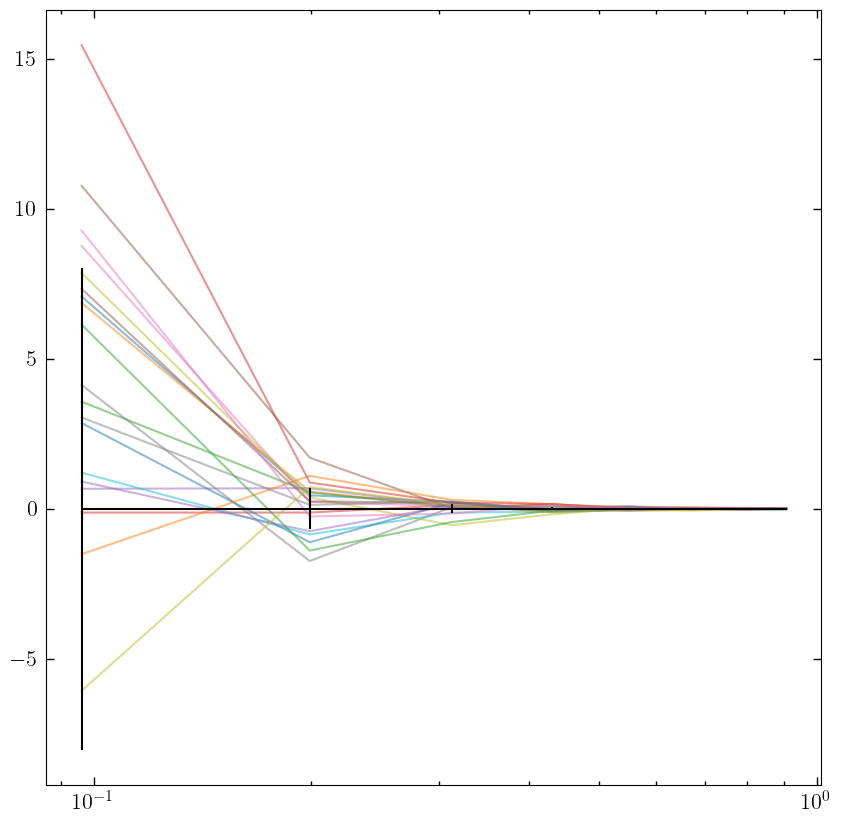

In [121]:
sidx=0
ell=2
for i in range(len(pell_ij_poles_list)):
    plt.semilogx(kcut, dlist[i]/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1), alpha=0.5)
plt.errorbar(kcut, np.zeros_like(kcut), delta_std, color='k')
#plt.errorbar(k[nstart:ncut+nstart], np.zeros_like(pk_zb_conv[sidx,ell,nstart:ncut+nstart]), np.sqrt(np.diag(covs_ub[sidx])[ell*nkout:][nstart:ncut+nstart]), color='r')

#plt.semilogx(k[nstart:ncut+nstart], pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zb_conv[sidx,ell,nstart:ncut+nstart], ls='--')


In [232]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pell_ij_poles_list_fullcut = []
pk_ij_interlaced_list_fullcut = []

for i in range(10):
    print(i)
    basename = '/global/cfs/projectdirs/cosmosim/slac/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced/'.format(i)
    pk_zz_fname_rs = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
    pk_ij_interlaced_list_fullcut.append(pk_ij_zz_i_interlaced)

    pell_ij_poles_list_fullcut.append(pk_ij_zz_poles_i)

pell_ij_poles_fullcut = np.mean(np.stack(pell_ij_poles_list_fullcut), axis=0)
pell_ij_poles_fullcut_std = np.std(np.stack(pell_ij_poles_list_fullcut), axis=0)/len(pell_ij_poles_list)

pk_ij_interlaced_fullcut = np.mean(np.stack(pk_ij_interlaced_list_fullcut), axis=0)
pk_ij_interlaced_fullcut_std = np.std(np.stack(pk_ij_interlaced_list_fullcut), axis=0)/len(pk_ij_interlaced_list)



0
1
2
3
4
5
6
7
8
9


/tmp/ipykernel_173729/3228801853.py:20: RuntimeWarning: divide by zero encountered in divide
  pell_ij_poles_fullcut_std = np.std(np.stack(pell_ij_poles_list_fullcut), axis=0)/len(pell_ij_poles_list)
/tmp/ipykernel_173729/3228801853.py:23: RuntimeWarning: divide by zero encountered in divide
  pk_ij_interlaced_fullcut_std = np.std(np.stack(pk_ij_interlaced_list_fullcut), axis=0)/len(pk_ij_interlaced_list)


In [240]:
pell_ij_poles_list_fullcut[0].shape

(15, 3, 699)

In [231]:
pk_zenbu_poles_highres_fullcut, pspline_fullcut, lptobj_fullcut = zenbu_spectra_highres(k, z_this, anzu_config, kth, p_m_lin * np.tanh(kth/(2 * np.pi / lbox)),
                                                                N=2700, jn=15, cutoff=np.pi * cfg['nmesh_in'] / cfg['lbox'], ngauss=12)


/global/homes/j/jderose/project/ZeNBu/Utils/spherical_bessel_transform_fftw.py:102: RuntimeWarning: invalid value encountered in multiply
  self.gks[:] = np.conj(fks * self.udict[nu])
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:371: RuntimeWarning: overflow encountered in multiply
  bias_integrands = bias_integrands * expon * (-2./k/self.qint)**l
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:368: RuntimeWarning: overflow encountered in multiply
  bias_integrands = bias_integrands * expon * (-2./k/self.qint)**l
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:295: RuntimeWarning: overflow encountered in exp
  expon = np.exp(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:296: RuntimeWarning: overflow encountered in expm1
  exponm1 = np.expm1(-0.5*Ksq

In [233]:
kt = kth#np.logspace(-3,1,10000)

ngauss = 12
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
pknutable = lptobj_fullcut.pknutable

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

        
p0table = lptobj_fullcut.p0ktable
p2table = lptobj_fullcut.p2ktable
p4table = lptobj_fullcut.p4ktable
p6table = 4.5 * np.sum((ws*L4)[:,None,None]*pknutable,axis=0)

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table


pell_convs_fullcut = []

for i in range(3):
    pell_in = [p0table[:,i], p2table[:,i], p4table[:,i]]#, p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs_fullcut.append(pell_conv.reshape(3,-1))
    
kin = kth

In [237]:
pell_convs_fullcut = np.stack(pell_convs_fullcut)

In [249]:
pk_zenbu_highres_fullcut, pspline_fullcut, lptobj_fullcut = zenbu_spectra_highres(k, z_this, anzu_config, kth, p_m_lin * np.tanh(kth/(2 * np.pi / lbox)),
                                                                N=2700, jn=15, cutoff=np.pi * cfg['nmesh_in'] / cfg['lbox'], ngauss=12, rsd=False)


In [251]:
sidx

2

In [252]:
pk_ij_interlaced_fullcut.shape

(15, 699, 1)

In [253]:
pk_zenbu_highres_fullcut.shape

(11, 699)

(0.0, 1.0)

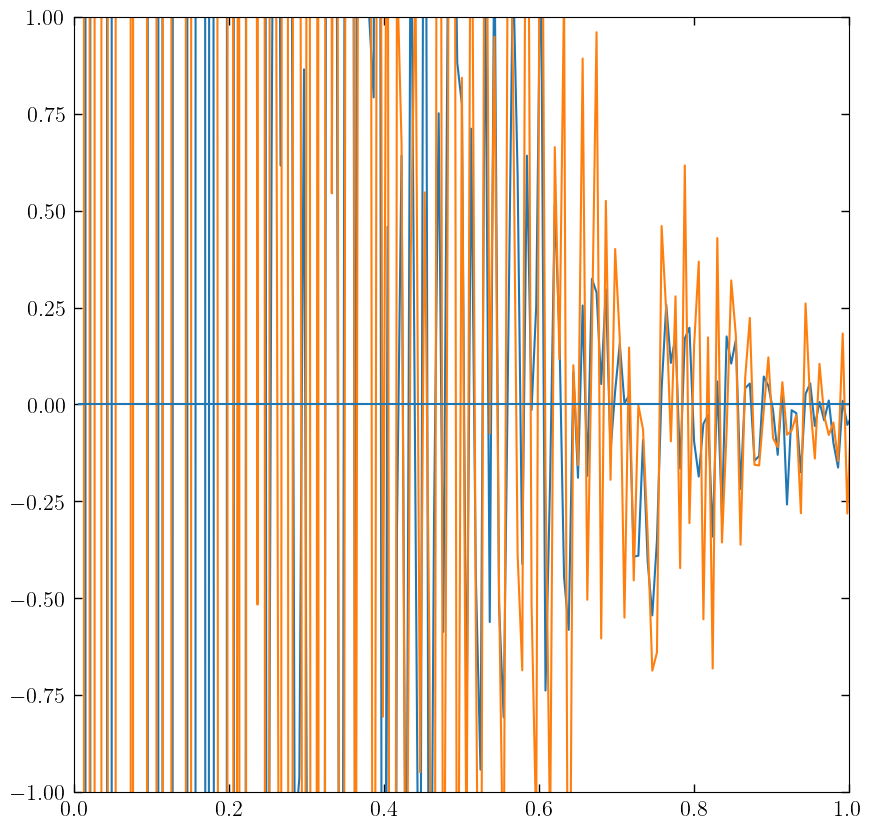

In [295]:
sidx=0
ell=0
#plt.semilogx(k, pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:])
for ell in range(2,3):
    plt.plot(k, pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:])
    plt.plot(k, pell_ij_poles[sidx,ell,:] - pk_zenbu_poles_highres[sidx,ell,:])
#plt.semilogx(k, pell_ij_poles[sidx,ell,:])
plt.hlines(0, k[0], k[-1])
plt.ylim([-1,1])
plt.xlim([0,1])

(-1.0, 1.0)

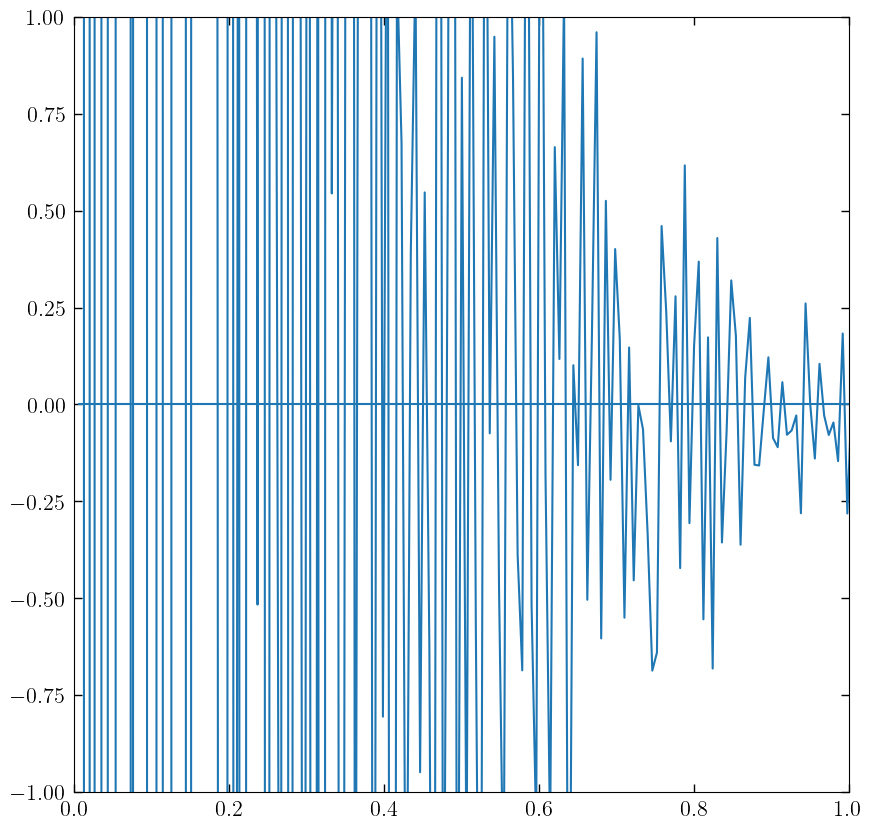

In [291]:
#plt.plot(k, pk_ij_interlaced_fullcut[sidx,:,0] - pk_zenbu_highres_fullcut[sidx,:])
#plt.semilogx(k, pell_ij_poles_fullcut[sidx,0,:] / pk_zenbu_poles_highres_fullcut[sidx,0,:] - 1)
plt.plot(k, pell_ij_poles[sidx,2,:] - pk_zenbu_poles_highres[sidx,2,:])
plt.plot(k, pell_ij_poles[sidx,ell,:]-pell_convs[sidx,ell,:])

plt.hlines(0,k[0], k[-1])
plt.xlim([0, 1])
plt.ylim([-1,1])

/tmp/ipykernel_173729/106466289.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 1])


(-0.01, 0.01)

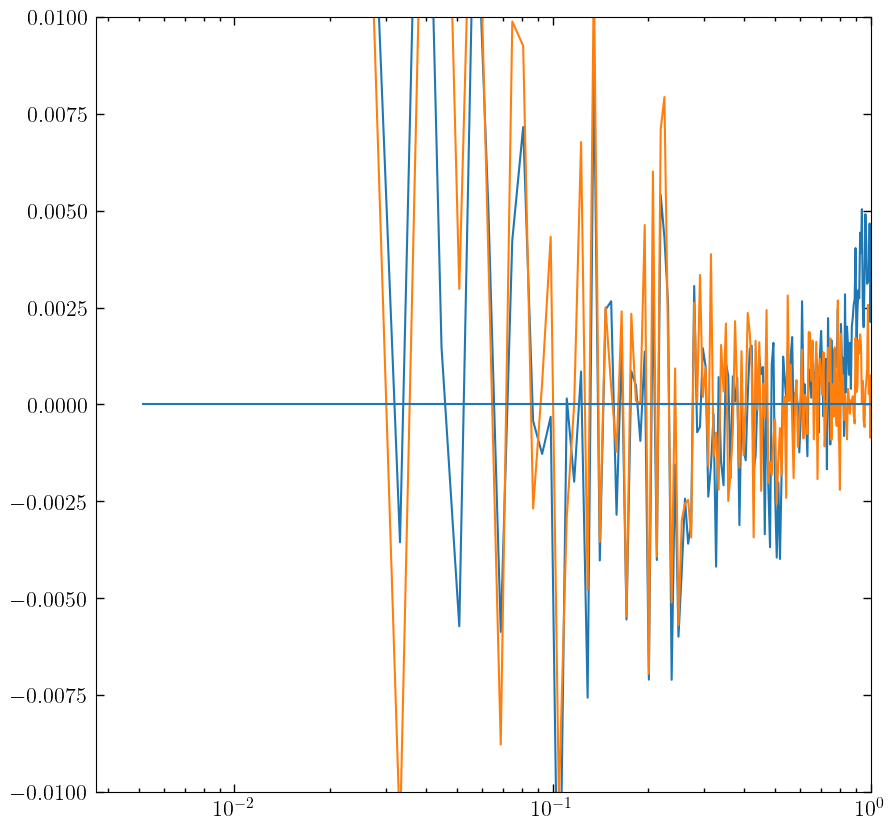

In [268]:
plt.semilogx(k, pk_ij_interlaced_fullcut[sidx,:,0] / pk_zenbu_highres_fullcut[sidx,:] - 1)
#plt.semilogx(k, pell_ij_poles_fullcut[sidx,0,:] / pk_zenbu_poles_highres_fullcut[sidx,0,:] - 1)
plt.semilogx(k, pell_ij_poles[sidx,0,:] / pk_zenbu_poles_highres[sidx,0,:] - 1)
plt.hlines(0,k[0], k[-1])
plt.xlim([0, 1])
plt.ylim([-0.01,0.01])

In [468]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pells = []
pell_dconvs = []
pell_ij_poles_list_dic = []
pk_ij_interlaced_list = []
pk_ij = []
#z_this = 3
#a_this = 1/(1 + z_this)
for i in range(10,20):

    print(i)
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/'.format(i)
    pk_zz_fname_rs = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
#    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
#    pk_ij_interlaced_list.append(pk_ij_zz_i_interlaced)

    pell_ij_poles_list_dic.append(pk_ij_zz_poles_i)

pell_ij_poles_dic = np.mean(np.stack(pell_ij_poles_list_dic), axis=0)
#pell_ij_poles_std = np.std(np.stack(pell_ij_poles_list), axis=0)/len(pell_ij_poles_list)

#pk_ij_interlaced = np.mean(np.stack(pk_ij_interlaced_list), axis=0)
#pk_ij_interlaced_std = np.std(np.stack(pk_ij_interlaced_list), axis=0)/len(pk_ij_interlaced_list)



10
11
12
13
14
15
16
17
18
19


In [463]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pells = []
pell_dconvs = []
pell_ij_poles_list_old = []
pk_ij_interlaced_list = []
pk_ij = []
#z_this = 3
#a_this = 1/(1 + z_this)
for i in range(10,19):

    print(i)
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut/'.format(i)
    pk_zz_fname_rs = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
#    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
#    pk_ij_interlaced_list.append(pk_ij_zz_i_interlaced)

    pell_ij_poles_list_old.append(pk_ij_zz_poles_i)

pell_ij_poles_old = np.mean(np.stack(pell_ij_poles_list_z3), axis=0)
#pell_ij_poles_std = np.std(np.stack(pell_ij_poles_list), axis=0)/len(pell_ij_poles_list)

#pk_ij_interlaced = np.mean(np.stack(pk_ij_interlaced_list), axis=0)
#pk_ij_interlaced_std = np.std(np.stack(pk_ij_interlaced_list), axis=0)/len(pk_ij_interlaced_list)



10
11
12
13
14
15
16
17
18


In [435]:
pk_zenbu_poles_highres_dic, pspline, lptobj = zenbu_spectra_highres(k, z_this, anzu_config, kth, p_m_lin * np.tanh(kth/(2 * np.pi / lbox)),
                                                                N=2700, jn=15, cutoff=np.pi * cfg['nmesh_in'] / cfg['lbox'] / 2, ngauss=12, Dic=0.103369)


/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:371: RuntimeWarning: overflow encountered in multiply
  bias_integrands = bias_integrands * expon * (-2./k/self.qint)**l
/global/homes/j/jderose/project/ZeNBu/Utils/spherical_bessel_transform_fftw.py:102: RuntimeWarning: invalid value encountered in multiply
  self.gks[:] = np.conj(fks * self.udict[nu])
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:295: RuntimeWarning: overflow encountered in exp
  expon = np.exp(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:296: RuntimeWarning: overflow encountered in expm1
  exponm1 = np.expm1(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:368: RuntimeWarning: overflow encountered in multiply
  bias_integrands = bias_integran

(-0.1, 0.1)

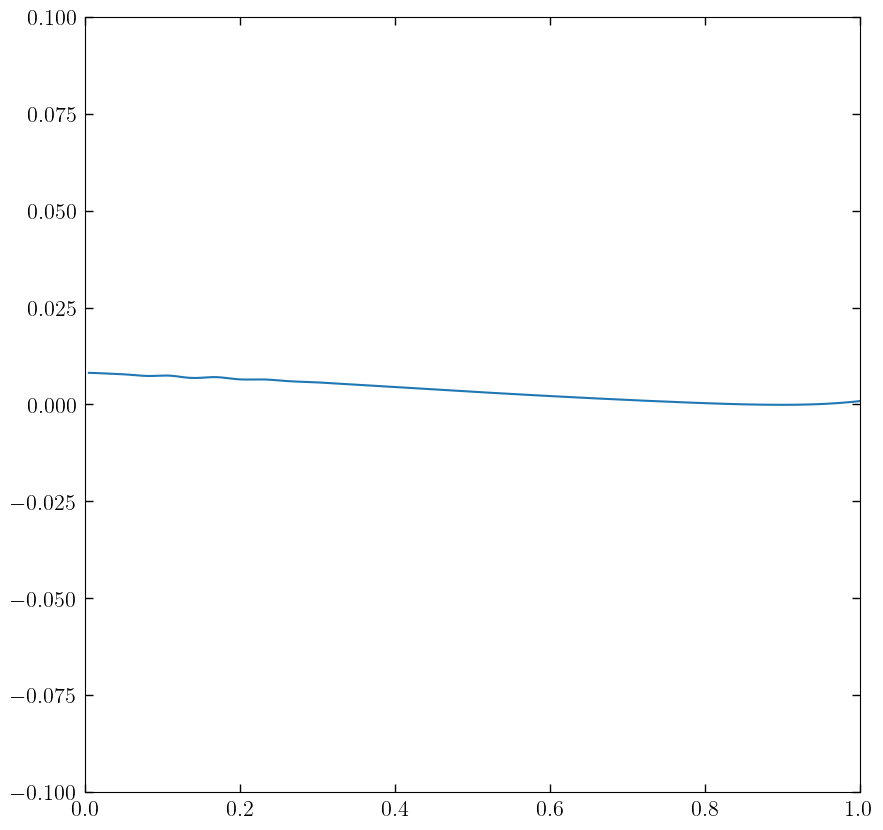

In [448]:
ell=0
sidx=0
plt.plot(k, pk_zenbu_poles_highres_dic[sidx,ell,:]/pk_zenbu_poles_highres[sidx,ell,:]-1)
plt.xlim([0, 1])
plt.ylim([-0.1, 0.1])

(0.0, 1.0)

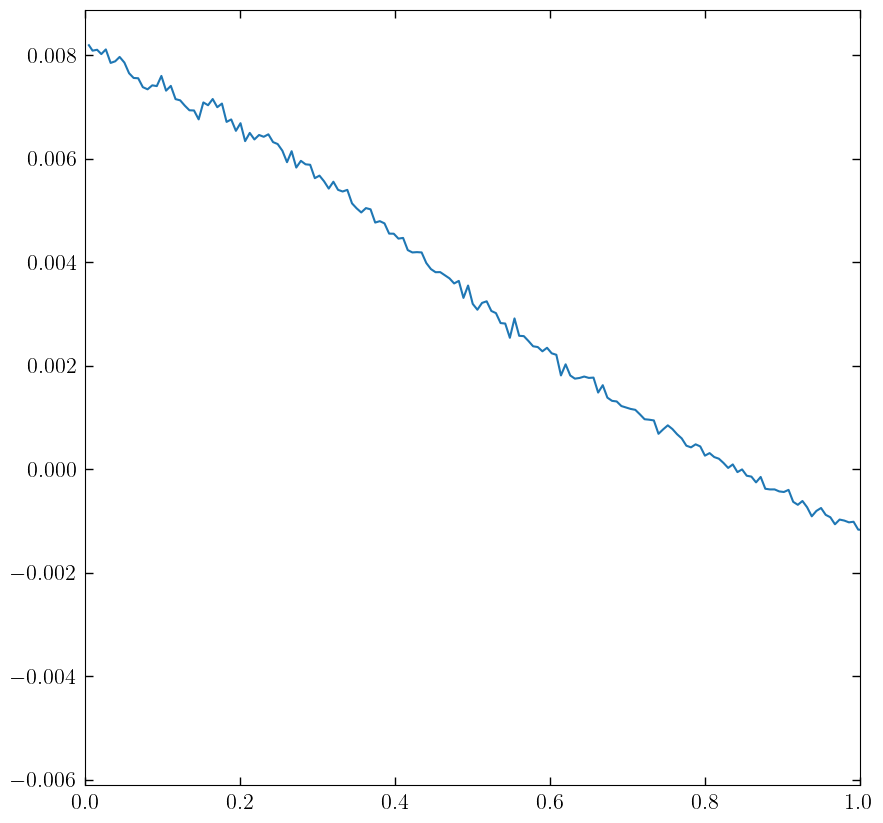

In [465]:
plt.plot(k, pell_ij_poles_list_dic[0][0,0,:]/pell_ij_poles_list_old[0][0,0,:]-1)
plt.xlim([0,1])
#plt.

In [457]:
kt = kth#np.logspace(-3,1,10000)

ngauss = 12
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
pknutable = lptobj.pknutable

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

        
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable
p6table = 6.5 * np.sum((ws*L6)[:,None,None]*pknutable,axis=0)

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table


pell_convs_dic = []

for i in range(3):
    pell_in = [p0table[:,i], p2table[:,i], p4table[:,i]]#, p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs_dic.append(pell_conv.reshape(3,-1))
    
kin = kth
pell_convs_dic = np.stack(pell_convs_dic)

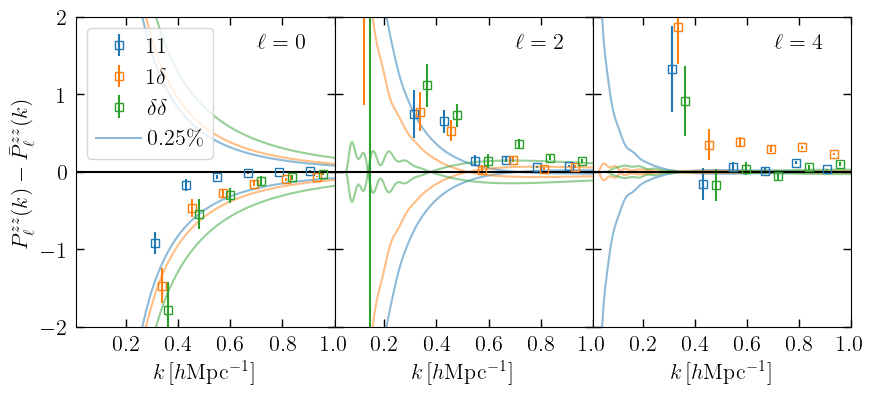

In [469]:
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline(kin) #* kin**2

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 0
V = 1050**3
kcut = np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin) * kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025

lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):

        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu = pell_convs_dic[sidx,ell,nstart:ncut+nstart]
        pk_zenbu_uc = pspline_kc1(k)
        
        dlist = []
        for i in range(len(pell_ij_poles_list_dic)):
            delta_i = (pell_ij_poles_list_dic[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]#* kd[nstart:ncut+nstart]**3
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
#        print(
        #delta_std = np.sqrt(var[sidx,ell,:])/9
        #delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
        delta = (pell_ij_poles_dic[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-2, 2])
#ax[1].set_ylim([-1, 1])
#ax[2].set_ylim([-1, 1])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))

f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


In [436]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pells = []
pell_dconvs = []
pell_ij_poles_list_z3 = []
pk_ij_interlaced_list = []
pk_ij = []
z_this = 3
a_this = 1/(1 + z_this)
lbox = 1050
nmesh = 1400
for i in range(10,20):

    print(i)
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut/'.format(i)
    pk_zz_fname_rs = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
#    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
#    pk_ij_interlaced_list.append(pk_ij_zz_i_interlaced)

    pell_ij_poles_list_z3.append(pk_ij_zz_poles_i)

pell_ij_poles_z3 = np.mean(np.stack(pell_ij_poles_list_z3), axis=0)
pell_ij_poles_std = np.std(np.stack(pell_ij_poles_list_z3), axis=0)/len(pell_ij_poles_list_z3)

#pk_ij_interlaced = np.mean(np.stack(pk_ij_interlaced_list), axis=0)
#pk_ij_interlaced_std = np.std(np.stack(pk_ij_interlaced_list), axis=0)/len(pk_ij_interlaced_list)



10
11
12
13
14
15
16
17
18
19


In [46]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pells = []
pell_dconvs = []
pell_ij_poles_list_z3 = []
pk_ij_interlaced_list = []
pk_ij = []
z_this = 3
a_this = 1/(1 + z_this)
lbox = 1050
nmesh = 1400
for i in range(10,20):

    print(i)
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/'.format(i)
    pk_zz_fname_rs = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
#    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
#    pk_ij_interlaced_list.append(pk_ij_zz_i_interlaced)

    pell_ij_poles_list_z3.append(pk_ij_zz_poles_i)

pell_ij_poles_z3 = np.mean(np.stack(pell_ij_poles_list_z3), axis=0)
pell_ij_poles_std = np.std(np.stack(pell_ij_poles_list_z3), axis=0)/len(pell_ij_poles_list_z3)

#pk_ij_interlaced = np.mean(np.stack(pk_ij_interlaced_list), axis=0)
#pk_ij_interlaced_std = np.std(np.stack(pk_ij_interlaced_list), axis=0)/len(pk_ij_interlaced_list)



10
11
12
13
14
15
16
17
18
19


In [18]:
pk_zenbu_poles_highres_z3, pspline_z3, lptobj_z3 = zenbu_spectra_highres(k, z_this, anzu_config, kth, p_m_lin * np.tanh(kth/(2 * np.pi / lbox)),
                                                                N=2700, jn=15, cutoff=np.pi * cfg['nmesh_in'] / cfg['lbox'] / 2, ngauss=12)


/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [437]:
kt = kth#np.logspace(-3,1,10000)

ngauss = 24
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
pknutable = lptobj_z3.pknutable

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

        
p0table = lptobj_z3.p0ktable
p2table = lptobj_z3.p2ktable
p4table = lptobj_z3.p4ktable
p6table = 6.5 * np.sum((ws*L6)[:,None,None]*pknutable,axis=0)

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table


pell_convs_z3 = []
nmesh = 350
for i in range(3):
    pell_in = [p0table[:,i], p2table[:,i], p4table[:,i]]#, p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs_z3.append(pell_conv.reshape(3,-1))
    
kin = kth
pell_convs_z3 = np.stack(pell_convs_z3)

NameError: name 'lptobj_z3' is not defined

In [445]:
kt = kth#np.logspace(-3,1,10000)

ngauss = 24
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
pknutable = lptobj.pknutable

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

        
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable
p6table = 6.5 * np.sum((ws*L6)[:,None,None]*pknutable,axis=0)

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table


pell_convs_z3 = []
nmesh = 350
for i in range(3):
    pell_in = [p0table[:,i], p2table[:,i], p4table[:,i], p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs_z3.append(pell_conv.reshape(3,-1))
    
kin = kth
pell_convs_z3 = np.stack(pell_convs_z3)

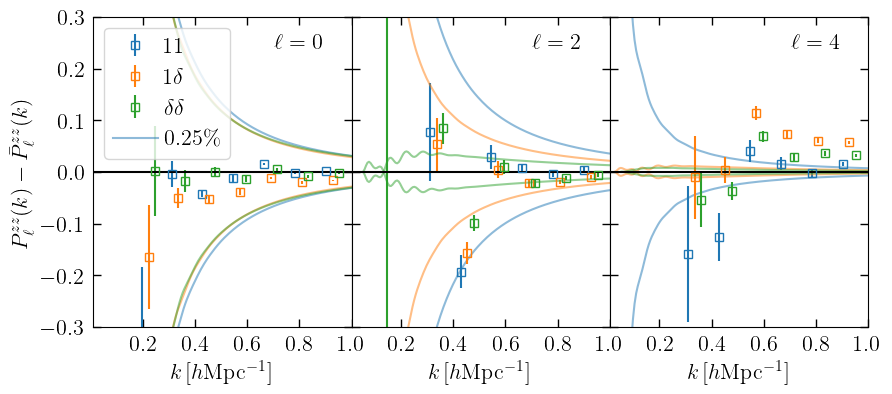

In [444]:
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline(kin) #* kin**2

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 0
V = 1050**3
kcut = np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin) * kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025

lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):

        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu = pell_convs[sidx,ell,nstart:ncut+nstart]
        pk_zenbu_uc = pspline_kc1(k)
        
        dlist = []
        for i in range(len(pell_ij_poles_list_z3)):
            delta_i = (pell_ij_poles_list_z3[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]#* kd[nstart:ncut+nstart]**3
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
#        print(
        #delta_std = np.sqrt(var[sidx,ell,:])/9
        #delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
        delta = (pell_ij_poles_z3[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-0.3, 0.3])
#ax[1].set_ylim([-1, 1])
#ax[2].set_ylim([-1, 1])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))

f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


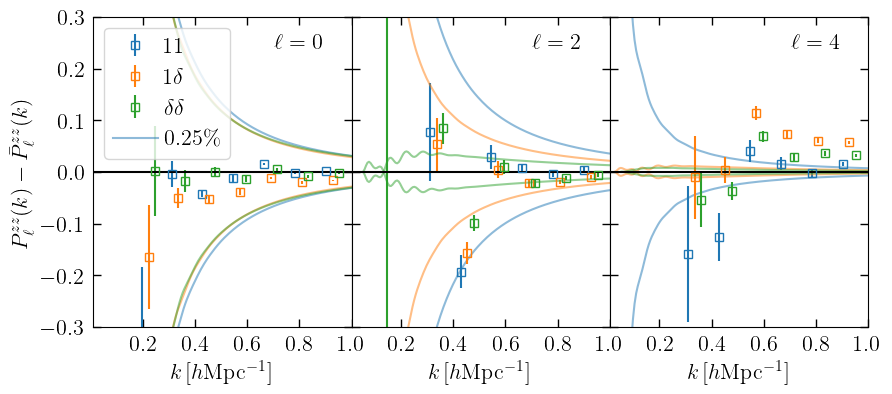

In [446]:
p0table = lptobj.p0ktable
p2table = lptobj.p2ktable
p4table = lptobj.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline(kin) #* kin**2

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 0
V = 1050**3
kcut = np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin) * kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025

lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):

        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu = pell_convs[sidx,ell,nstart:ncut+nstart]
        pk_zenbu_uc = pspline_kc1(k)
        
        dlist = []
        for i in range(len(pell_ij_poles_list_z3)):
            delta_i = (pell_ij_poles_list_z3[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]#* kd[nstart:ncut+nstart]**3
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
#        print(
        #delta_std = np.sqrt(var[sidx,ell,:])/9
        #delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
        delta = (pell_ij_poles_z3[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-0.3, 0.3])
#ax[1].set_ylim([-1, 1])
#ax[2].set_ylim([-1, 1])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))

f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


In [183]:
pin_samp = np.genfromtxt('/pscratch/sd/j/jderose/aemulus_nu_setup/Box76_1400/run/input_powerspec_sampled_SPT.txt')
pin = np.genfromtxt('/pscratch/sd/j/jderose/aemulus_nu_setup/Box76_1400/run/input_powerspec.txt')


(0.0, 1.0)

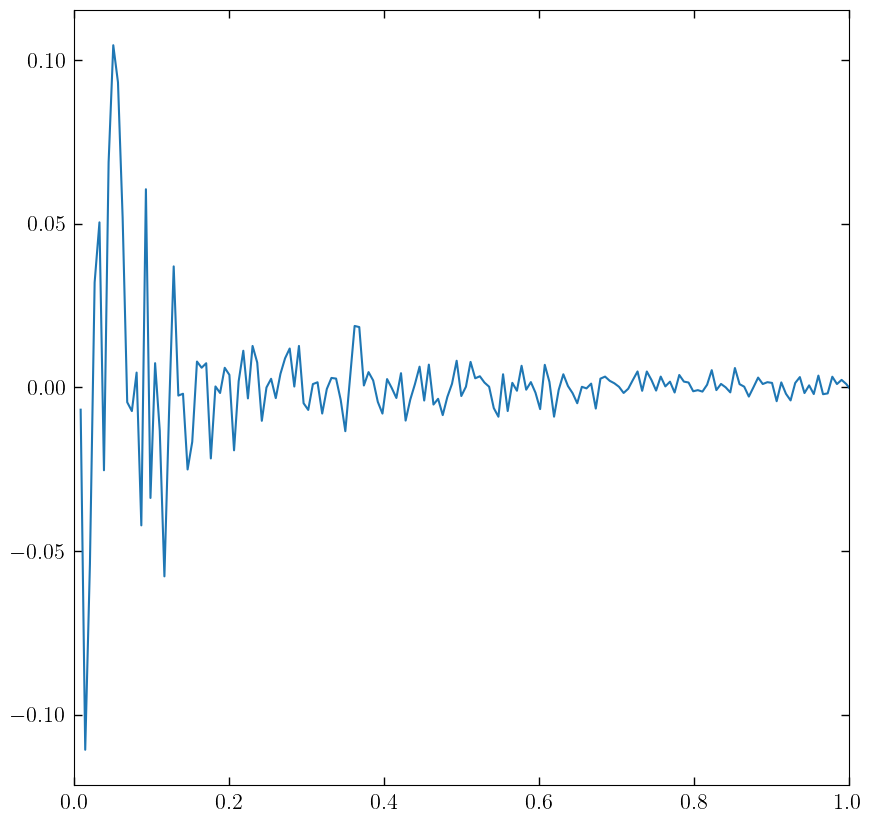

In [184]:
plt.plot(pin_samp[:,0], pin_samp[:,1]/interp1d(pin[:,0], pin[:,1])(pin_samp[:,0]) - 1)
plt.xlim([0,1])

In [41]:
pk_zenbu_poles_highres_z3_dic, pspline_z3_dic, lptobj_z3_dic = zenbu_spectra_highres(k, z_this, anzu_config, kth, p_m_lin * np.tanh(kth/(2 * np.pi / lbox)),
                                                                N=2700, jn=15, cutoff=np.pi * cfg['nmesh_in'] / cfg['lbox'] / 2, ngauss=12, Dic=0.103369)


/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:371: RuntimeWarning: overflow encountered in multiply
  bias_integrands = bias_integrands * expon * (-2./k/self.qint)**l
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:295: RuntimeWarning: overflow encountered in exp
  expon = np.exp(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:296: RuntimeWarning: overflow encountered in expm1
  exponm1 = np.expm1(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:368: RuntimeWarning: invalid value encountered in multiply
  bias_integrands = bias_integrands * expon * (-2./k/self.qint)**l
/global/homes/j/jderose/project/ZeNBu/Utils/spherical_bessel_transform_fftw.py:99: RuntimeWarning: overflow encountered in multiply
  self.fs[:,s

In [44]:
kt = kth#np.logspace(-3,1,10000)

ngauss = 12
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
pknutable = lptobj_z3_dic.pknutable

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

        
p0table = lptobj_z3_dic.p0ktable
p2table = lptobj_z3_dic.p2ktable
p4table = lptobj_z3_dic.p4ktable
p6table = 6.5 * np.sum((ws*L6)[:,None,None]*pknutable,axis=0)

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table


pell_convs_z3 = []
nmesh = 350
for i in range(3):
    pell_in = [p0table[:,i], p2table[:,i], p4table[:,i]]#, p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs_z3.append(pell_conv.reshape(3,-1))
    
kin = kth
pell_convs_z3 = np.stack(pell_convs_z3)

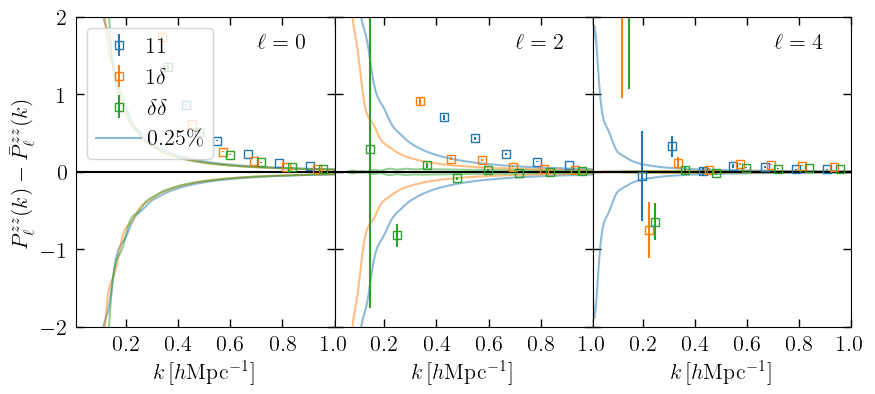

In [47]:
p0table = lptobj_z3.p0ktable
p2table = lptobj_z3.p2ktable
p4table = lptobj_z3.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline_z3(kin) #* kin**2

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 0
V = 1050**3
kcut = np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin) * kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025

lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):

        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu = pell_convs_z3[sidx,ell,nstart:ncut+nstart]
        pk_zenbu_uc = pspline_kc1(k)
        
        dlist = []
        for i in range(len(pell_ij_poles_list_z3)):
            delta_i = (pell_ij_poles_list_z3[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]#* kd[nstart:ncut+nstart]**3
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)

        #delta_std = np.sqrt(var[sidx,ell,:])/9
        #delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
        delta = (pell_ij_poles_z3[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-2, 2])
#ax[1].set_ylim([-1, 1])
#ax[2].set_ylim([-1, 1])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))

f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


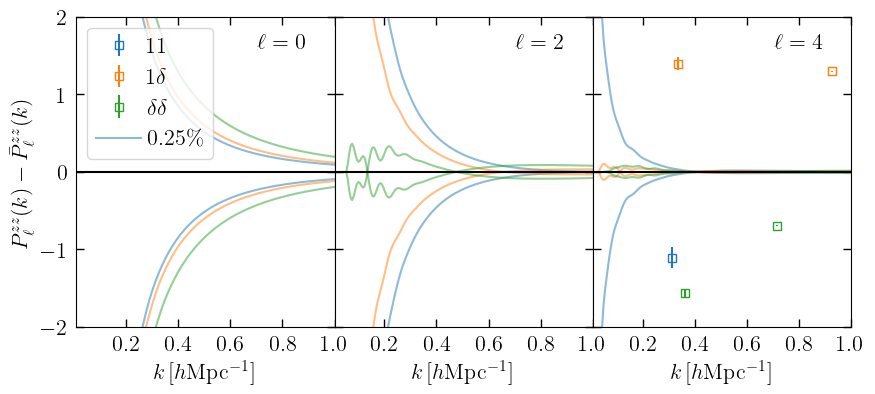

In [459]:
p0table = lptobj_4xs.p0ktable
p2table = lptobj_4xs.p2ktable
p4table = lptobj_4xs.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline_4xs(kin) #* kin**2

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 0
V = 1050**3
kcut = np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin) * kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025

lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):

        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu = pell_convs[sidx][ell,nstart:ncut+nstart]
        pk_zenbu_uc = pspline_kc1(k)
        
        dlist = []
        for i in range(len(pell_ij_poles_list_z3)):
            delta_i = (pell_ij_poles_list_z3[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]#* kd[nstart:ncut+nstart]**3
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)

        #delta_std = np.sqrt(var[sidx,ell,:])/9
        #delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
        delta = (pell_ij_poles_z3[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-2, 2])
#ax[1].set_ylim([-1, 1])
#ax[2].set_ylim([-1, 1])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))

f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')


In [424]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pells = []
pell_dconvs = []
pell_ij_poles_list_lin = []
pk_ij_list = []
pk_ij_nosmooth_list = []

pk_ij = []
z_this = 3
a_this = 1/(1 + z_this)
lbox = 1050
nmesh = 1400
for i in range(10,20):
    if i==13: continue
    print(i)
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/'.format(i)
    pk_zz_fname_rs = basename + 'pk_lin_rsd=False_pypower=True_nmesh0.2499999998198657.npy'
    pk_zz_fname = basename + 'pk_lin_rsd=True_pypower=True_nmesh0.2499999998198657.npy'
    
#    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
#    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
#    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
#    pk_ij_interlaced_list.append(pk_ij_zz_i_interlaced)
    pklin = np.load('/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/pk_lin_rsd=True_pypower=True_nmesh0.2499999998198657.npy'.format(i), allow_pickle=True)    
    pklin_rs = np.load('/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/pk_lin_rsd=False_pypower=True_nmesh0.2499999998198657.npy'.format(i), allow_pickle=True)    
    pklin_rs_ns = np.load('/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/pk_lin_nosmooth_rsd=False_pypower=True_nmesh0.2499999998198657.npy'.format(i), allow_pickle=True)    
   
    pell_ij_poles_list_lin.append(pklin[0][0][0]['power_poles'])
    pk_ij_list.append(pklin_rs[0][0][0]['power_wedges'])
    pk_ij_nosmooth_list.append(pklin_rs_ns[0][0][0]['power_wedges'])
    
pell_ij_poles_lin = np.mean(np.stack(pell_ij_poles_list_lin), axis=0)
p_ij_lin = np.mean(np.stack(pk_ij_list), axis=0)
pk_ij_nosmooth = np.mean(np.stack(pk_ij_nosmooth_list), axis=0)
#pell_ij_poles_std = np.std(np.stack(pell_ij_poles_list_z3), axis=0)/len(pell_ij_poles_list_z3)

#pk_ij_interlaced = np.mean(np.stack(pk_ij_interlaced_list), axis=0)
#pk_ij_interlaced_std = np.std(np.stack(pk_ij_interlaced_list), axis=0)/len(pk_ij_interlaced_list)



10
11
12
14
15
16
17
18
19


(-2.0, 2.0)

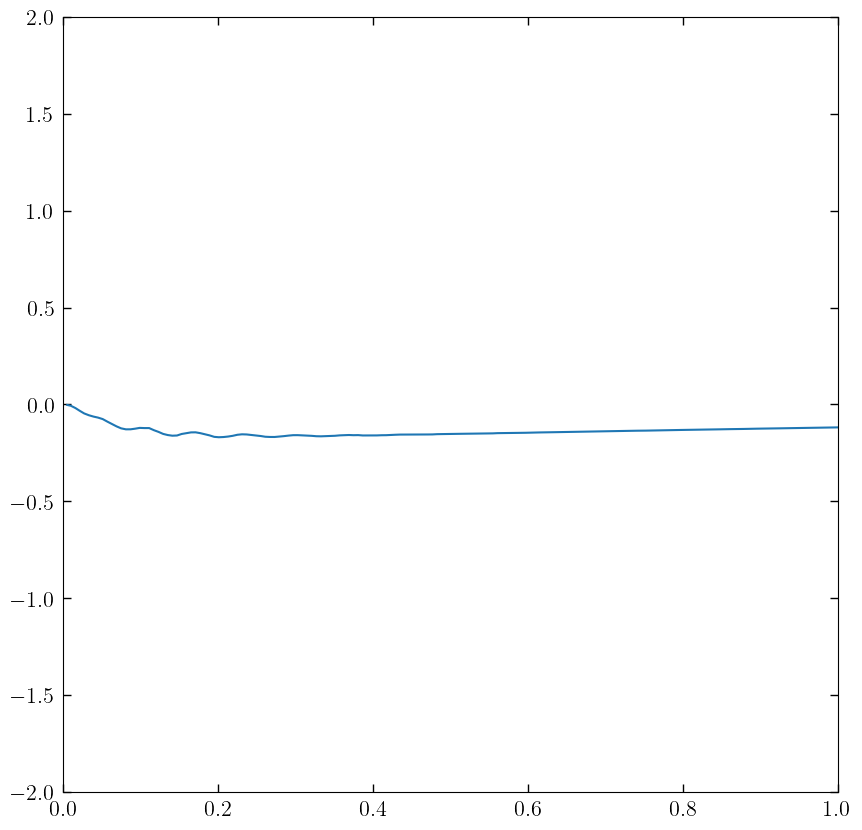

In [140]:
plt.plot(k, p_ij_lin - pk_ij_nosmooth)
plt.xlim([0, 1])
plt.ylim([-2,2])

In [5]:
with open(anzu_config, 'r') as fp:
    cfg = yaml.load(fp, Loader=Loader)
pkclass = Class()
pkclass.set(cfg["Cosmology"])
pkclass.compute()


In [351]:
kt = kth

ngauss = 12
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
k_grid, nu_grid = np.meshgrid(kt, nus)
pknutable = p_m_lin * (1 + f * nu_grid**2)**2 

f = pkclass.scale_independent_growth_factor_f(12)
L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

p0table = 0.5 * np.sum((ws*L0)[:,None]*pknutable,axis=0)
p2table = 2.5 * np.sum((ws*L2)[:,None]*pknutable,axis=0)
p4table = 4.5 * np.sum((ws*L4)[:,None]*pknutable,axis=0)
p6table = 6.5 * np.sum((ws*L6)[:,None]*pknutable,axis=0)

pell_convs_lin = []

nmesh = 350
nmesh_fid = 1400
lbox = 1050
kout = np.linspace(0, nmesh_fid * np.pi / lbox, int(nmesh_fid // 2))
nko = len(kout)-1

for i in range(1):
    pell_in = [p0table.T, p2table.T, p4table.T]#, p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs_lin.append(pell_conv.reshape(3,-1))
    
kin = kth
pell_convs_lin_nosmooth = np.stack(pell_convs_lin)

In [353]:
kt = kth

ngauss = 12
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
k_grid, nu_grid = np.meshgrid(kt, nus)
f = pkclass.scale_independent_growth_factor_f(12)

pknutable = p_m_lin * (1 + f * nu_grid**2)**2 * np.exp(-kt**2 / (cutoff**2))

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

p0table = 0.5 * np.sum((ws*L0)[:,None]*pknutable,axis=0)
p2table = 2.5 * np.sum((ws*L2)[:,None]*pknutable,axis=0)
p4table = 4.5 * np.sum((ws*L4)[:,None]*pknutable,axis=0)
p6table = 6.5 * np.sum((ws*L6)[:,None]*pknutable,axis=0)

pell_convs_lin = []

nmesh = 350
nmesh_fid = 1400
lbox = 1050
kout = np.linspace(0, nmesh_fid * np.pi / lbox, int(nmesh_fid // 2))
nko = len(kout)-1

for i in range(1):
    pell_in = [p0table.T, p2table.T, p4table.T]#, p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs_lin.append(pell_conv.reshape(3,-1))
    
kin = kth
pell_convs_lin = np.stack(pell_convs_lin)

(-1000.0, 1000.0)

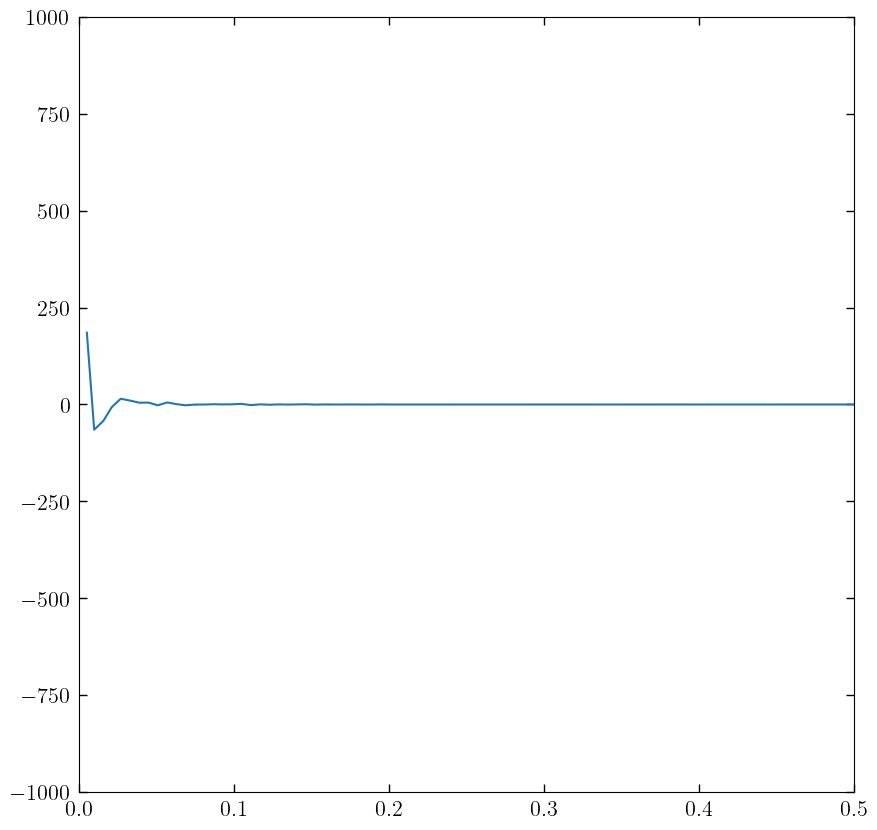

In [373]:
ncut = 160
rebin = 10
nstart = 0
V = 1050**3
for ell in range(1):
    delta = (pell_ij_poles_lin[ell,:]-pell_convs_lin[0,ell,:]) 
#    delta = np.sum(delta.reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
    plt.plot(k, delta)
plt.xlim([0,0.5])
plt.ylim(-1000,1000)

In [363]:
pell_convs_lin_nosmooth.shape

(1, 3, 699)

In [364]:
pk_ij_nosmooth.shape

(699, 1)

(-0.3, 0.3)

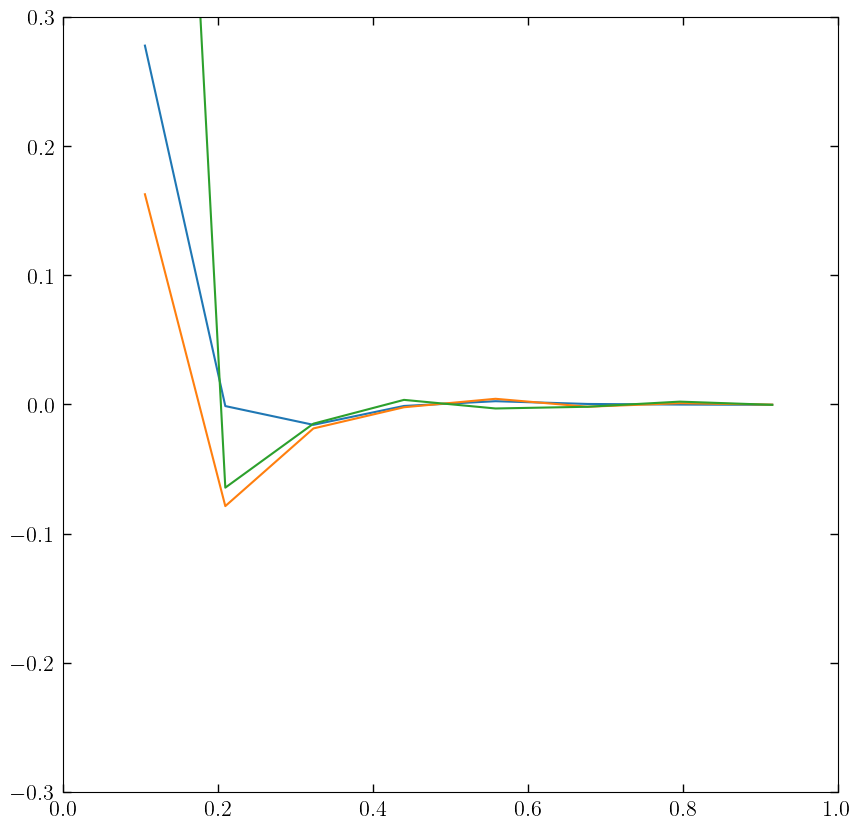

In [374]:
ncut = 160
rebin = 20
nstart = 2
V = 1050**3
kcut = np.sum(k[nstart:ncut+nstart].reshape(-1,rebin) * k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025
for ell in range(3):
    delta = (pell_ij_poles_lin[ell,nstart:ncut+nstart]-pell_convs_lin[0,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
    delta = np.sum(delta.reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        
#    delta = (pk_ij_nosmooth[ell,nstart:ncut+nstart]-pell_convs_lin_nosmooth[0,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
#    delta = np.sum(delta.reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
    plt.plot(kcut, delta, color='C{}'.format(ell))
    
plt.xlim([0,1])
plt.ylim(-0.3,0.3)

In [425]:
cutoff = np.pi * cfg['nmesh_in'] / cfg['lbox'] / 2
dk = 0.000
p_m_lin_eval = np.exp(interp1d(np.log(kth), np.log(p_m_lin), fill_value='extrapolate', kind='cubic')(np.log(keff + dk))) * np.exp(-(keff + dk)**2 / (cutoff**2))
p_m_lin_eval_nosmooth = np.exp(interp1d(np.log(kth), np.log(p_m_lin), fill_value='extrapolate', kind='cubic')(np.log(keff+dk)))


/tmp/ipykernel_104711/1086222777.py:3: RuntimeWarning: divide by zero encountered in log
  p_m_lin_eval = np.exp(interp1d(np.log(kth), np.log(p_m_lin), fill_value='extrapolate', kind='cubic')(np.log(keff + dk))) * np.exp(-(keff + dk)**2 / (cutoff**2))
/tmp/ipykernel_104711/1086222777.py:4: RuntimeWarning: divide by zero encountered in log
  p_m_lin_eval_nosmooth = np.exp(interp1d(np.log(kth), np.log(p_m_lin), fill_value='extrapolate', kind='cubic')(np.log(keff+dk)))


(-0.2, 0.2)

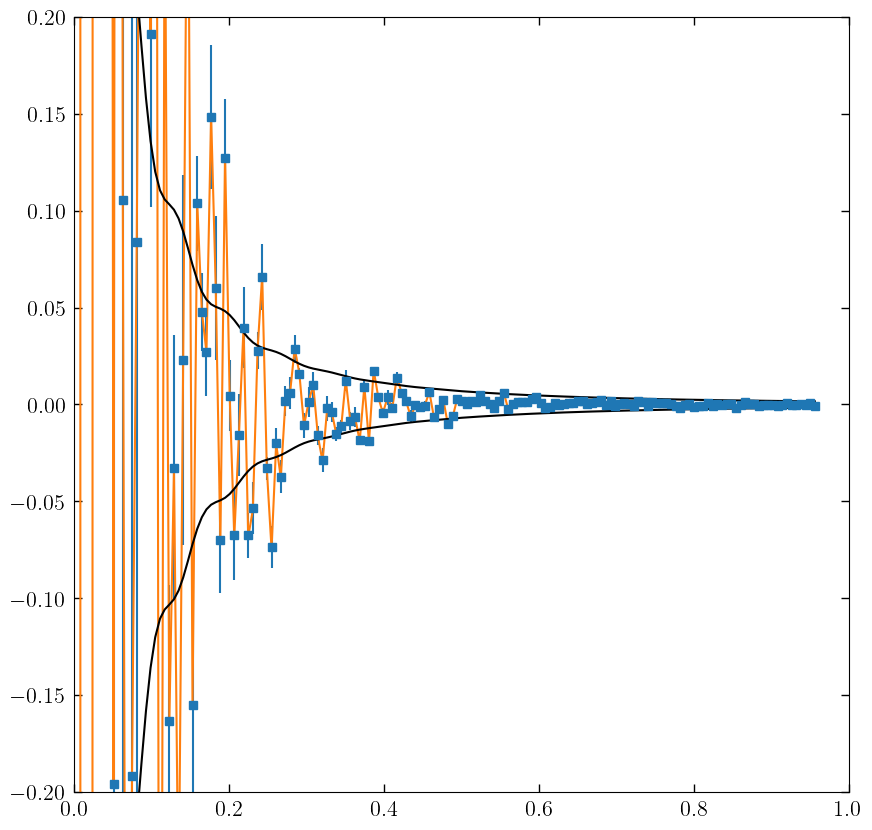

In [426]:
ncut = 160
rebin = 10
nstart = 0
V = 1050**3
kcut = np.sum(k[nstart:ncut+nstart].reshape(-1,rebin) * k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025

deltas = []

for i in range(len(pk_ij_nosmooth_list)):
    delta = (pk_ij_nosmooth_list[i][nstart:ncut+nstart,0]-p_m_lin_eval_nosmooth[nstart:ncut+nstart]) 
    deltas.append(delta)
    
delta_std = np.std(np.stack(deltas), axis=0) / len(deltas)
    
delta = (p_ij_lin[nstart:ncut+nstart,0]-p_m_lin_eval[nstart:ncut+nstart])
plt.errorbar(k[nstart:ncut+nstart], delta, delta_std, ls='', marker='s')

delta = (pk_ij_nosmooth[nstart:ncut+nstart,0]-p_m_lin_eval_nosmooth[nstart:ncut+nstart])
plt.plot(k[nstart:ncut+nstart], delta)
plt.plot(k[nstart:ncut+nstart], 0.0025 * p_m_lin_eval_nosmooth[nstart:ncut+nstart], color='k')
plt.plot(k[nstart:ncut+nstart], -0.0025 * p_m_lin_eval_nosmooth[nstart:ncut+nstart], color='k')
#plt.plot(pin_samp[:,0], (pin_samp[:,1] - interp1d(pin[:,0], pin[:,1])(pin_samp[:,0])) * (2 * np.pi)**3 )
#plt.plot(pin_samp[:,0], pin_samp[:,1]/interp1d(pin[:,0], pin[:,1])(pin_samp[:,0]) - 1)

plt.xlim([0,1])
plt.ylim(-0.2,0.2)

(-0.1, 0.1)

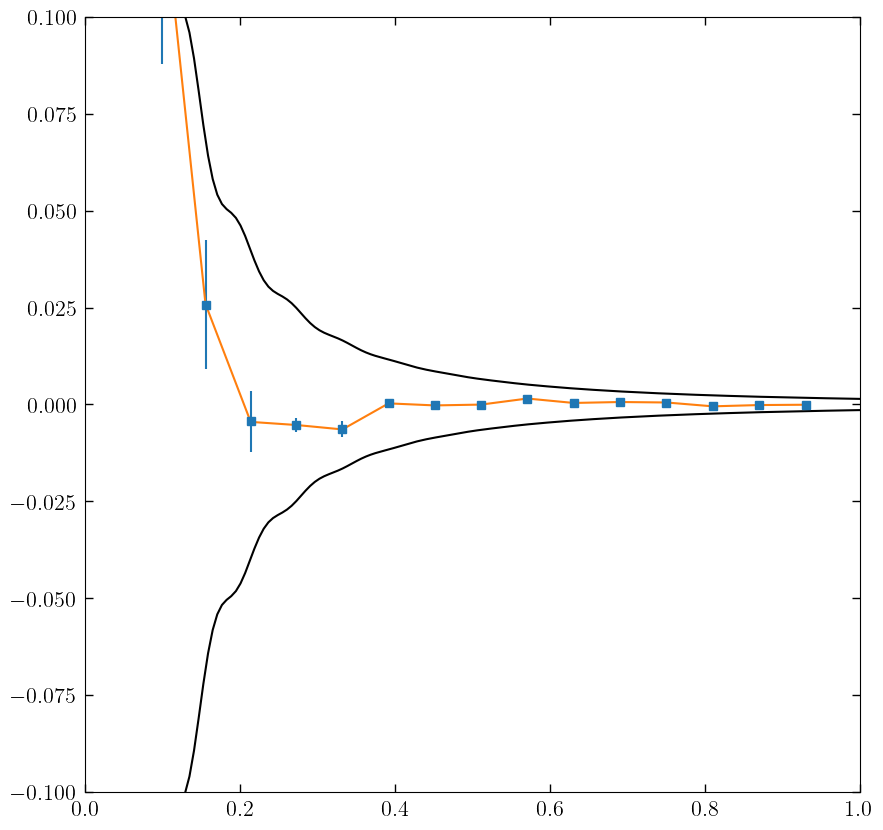

In [362]:
ncut = 160
rebin = 10
nstart = 0
V = 1050**3
kcut = np.sum(k[nstart:ncut+nstart].reshape(-1,rebin) * k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025

deltas = []

for i in range(len(pk_ij_nosmooth_list)):
    delta = (pk_ij_nosmooth_list[i][nstart:ncut+nstart,0]-p_m_lin_eval_nosmooth[nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
    delta = np.sum(delta.reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
    deltas.append(delta)
    
delta_std = np.std(np.stack(deltas), axis=0) / len(deltas)
    
delta = (p_ij_lin[nstart:ncut+nstart,0]-p_m_lin_eval[nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
delta = np.sum(delta.reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
plt.errorbar(kcut, delta, delta_std, ls='', marker='s')

delta = (pk_ij_nosmooth[nstart:ncut+nstart,0]-p_m_lin_eval_nosmooth[nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
delta = np.sum(delta.reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
plt.plot(kcut, delta)
plt.plot(k, 0.0025 * p_m_lin_eval_nosmooth, color='k')
plt.plot(k, -0.0025 * p_m_lin_eval_nosmooth, color='k')

plt.xlim([0,1])
plt.ylim(-0.1,0.1)

In [380]:
p_m_lin_eval = interp1d(kth, p_m_lin, fill_value='extrapolate')(keff) 

(-2.0, 2.0)

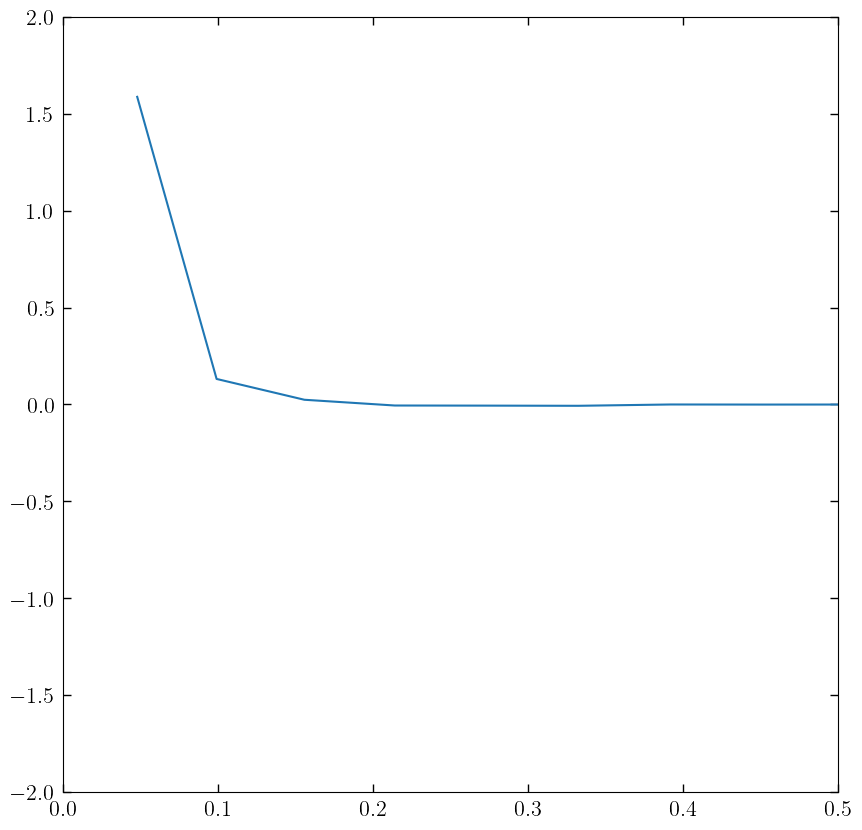

In [381]:
ncut = 160
rebin = 10
nstart = 0
V = 1050**3
kcut = np.sum(k[nstart:ncut+nstart].reshape(-1,rebin) * k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025
delta = (pk_ij_nosmooth[nstart:ncut+nstart,0]-p_m_lin_eval[nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
delta = np.sum(delta.reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
plt.plot(kcut, delta)
plt.xlim([0,0.5])
plt.ylim(-2,2)

(-2.0, 2.0)

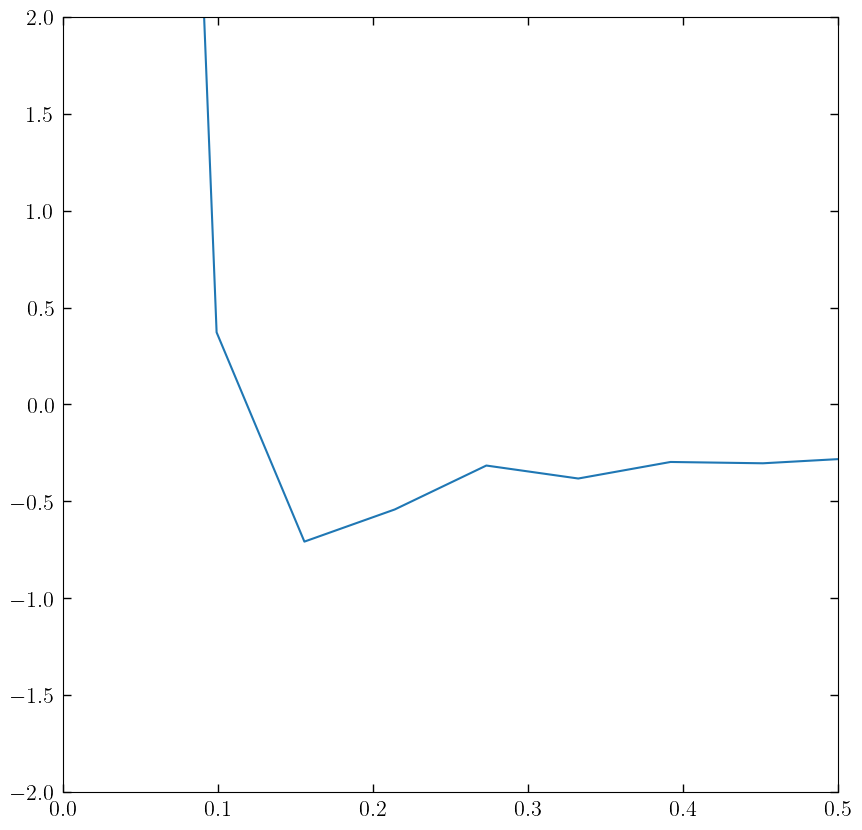

In [58]:
ncut = 160
rebin = 10
nstart = 0
V = 1050**3
kcut = np.sum(k[nstart:ncut+nstart].reshape(-1,rebin) * k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(k[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025

delta = (pell_ij_poles_lin[ell,nstart:ncut+nstart]-pell_convs_lin[0,ell,nstart:ncut+nstart]) * nmodes[nstart:ncut+nstart]
delta = np.sum(delta.reshape(-1,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
for ell in range(1):
    plt.plot(kcut, delta)
plt.xlim([0,0.5])
plt.ylim(-2,2)

In [62]:
pklin[0][0][0]['power_poles']

array([[ 5.78454199e+02,  6.97412952e+02,  4.54501265e+02, ...,
         6.17964944e-04,  6.09034051e-04,  5.99829083e-04],
       [ 1.25942447e+03,  7.07914115e+02,  2.77211680e+02, ...,
         6.14323421e-04,  6.07091492e-04,  5.97271148e-04],
       [ 3.98145330e+03, -5.95157603e+02, -6.27980875e+02, ...,
         7.12929018e-05,  7.02104777e-05,  7.32499376e-05]])

In [100]:
pklin_rs = np.load('/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/pk_lin_rsd=False_pypower=True_nmesh0.2499999998198657.npy'.format(10), allow_pickle=True)    
pklin_rs_nms = np.load('/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic_nomeansub/pk_lin_rsd=False_pypower=True_nmesh0.2499999998198657.npy'.format(10), allow_pickle=True)    
pklin_rs_ns = np.load('/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/pk_lin_nosmooth_rsd=False_pypower=True_nmesh0.2499999998198657.npy'.format(10), allow_pickle=True)    


(-2.0, 2.0)

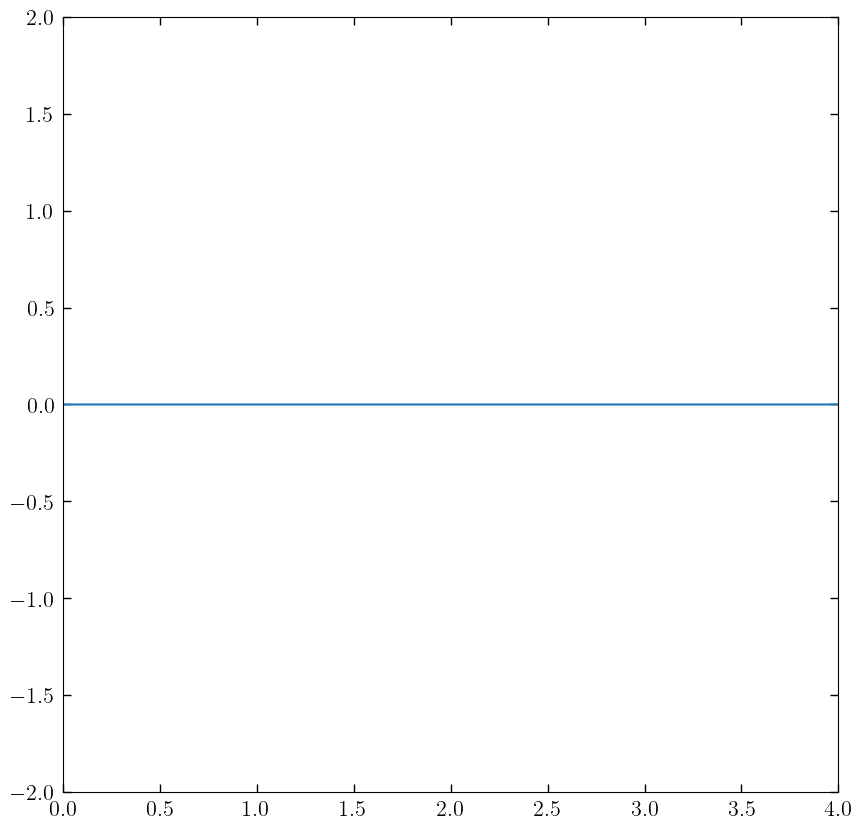

In [101]:
plt.plot(k, (pklin_rs[0][0][0]['power_wedges'][:,0]-pklin_rs_nms[0][0][0]['power_wedges'][:,0]))
plt.xlim([0,4])
plt.ylim([-2,2])

In [119]:
pk_zenbu_poles_highres_fullcut, pspline_fullcut, lptobj_fullcut = zenbu_spectra_highres(k, z_this, anzu_config, kth, p_m_lin * np.tanh(kth/(2 * np.pi / lbox)),
                                                                N=2700, jn=15, cutoff=np.pi * cfg['nmesh_in'] / cfg['lbox'], ngauss=12, Dic=0.103369)

pk_zenbu_poles_highres_nofilt, pspline_nofilt, lptobj_nofilt = zenbu_spectra_highres(k, z_this, anzu_config, kth, p_m_lin * np.tanh(kth/(2 * np.pi / lbox)),
                                                                N=2700, jn=15, cutoff=10, ngauss=12, Dic=0.103369)


/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:371: RuntimeWarning: overflow encountered in multiply
  bias_integrands = bias_integrands * expon * (-2./k/self.qint)**l
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:295: RuntimeWarning: overflow encountered in exp
  expon = np.exp(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:296: RuntimeWarning: overflow encountered in expm1
  exponm1 = np.expm1(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:368: RuntimeWarning: invalid value encountered in multiply
  bias_integrands = bias_integrands * expon * (-2./k/self.qint)**l
/global/homes/j/jderose/project/ZeNBu/Utils/spherical_bessel_transform_fftw.py:99: RuntimeWarning: overflow encountered in multiply
  self.fs[:,s

In [128]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pells = []
pell_dconvs = []
pell_ij_poles_list_nocut = []
pk_ij_interlaced_list = []
pk_ij = []
a_this = 0.6504
z_this = 1/a_this - 1
lbox = 1050
nmesh = 1400
for i in range(10,11):

    print(i)
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_nofilt_dic/'.format(i)
    pk_zz_fname_rs = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
#    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
#    pk_ij_interlaced_list.append(pk_ij_zz_i_interlaced)

    pell_ij_poles_list_nocut.append(pk_ij_zz_poles_i)

pell_ij_poles_nocut = np.mean(np.stack(pell_ij_poles_list_nocut), axis=0)
pell_ij_poles_nocut_std = np.std(np.stack(pell_ij_poles_list_nocut), axis=0)/len(pell_ij_poles_list_nocut)

#pk_ij_interlaced = np.mean(np.stack(pk_ij_interlaced_list), axis=0)
#pk_ij_interlaced_std = np.std(np.stack(pk_ij_interlaced_list), axis=0)/len(pk_ij_interlaced_list)



10


In [129]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pells = []
pell_dconvs = []
pell_ij_poles_list_halfcut = []
pk_ij_interlaced_list = []
pk_ij = []
a_this = 0.6504
z_this = 1/a_this - 1
lbox = 1050
nmesh = 1400
for i in range(10,11):

    print(i)
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_halfcut_dic/'.format(i)
    pk_zz_fname_rs = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
#    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
#    pk_ij_interlaced_list.append(pk_ij_zz_i_interlaced)

    pell_ij_poles_list_halfcut.append(pk_ij_zz_poles_i)

pell_ij_poles_halfcut = np.mean(np.stack(pell_ij_poles_list_halfcut), axis=0)
pell_ij_poles_halfcut_std = np.std(np.stack(pell_ij_poles_list_halfcut), axis=0)/len(pell_ij_poles_list_halfcut)

#pk_ij_interlaced = np.mean(np.stack(pk_ij_interlaced_list), axis=0)
#pk_ij_interlaced_std = np.std(np.stack(pk_ij_interlaced_list), axis=0)/len(pk_ij_interlaced_list)



10


In [450]:
pk_zenbu_poles_4xs, pspline_4xs, lptobj_4xs = zenbu_spectra_highres(k, z_this, anzu_config, kth, p_m_lin * np.tanh(kth/(2 * np.pi / lbox)),
                                                                N=2700, jn=15, cutoff=np.pi * cfg['nmesh_in'] / cfg['lbox'] / 4, ngauss=24)


In [462]:
#bvec = [3.7169027,  4.5469947, 0,  0]
bvec = [1.71690273,  1.09398937, 0, 0]
pells = []
pell_dconvs = []
pell_ij_poles_list = []
pk_ij_interlaced_list = []
pk_ij = []
a_this = 0.6504
z_this = 1/(a_this) - 1

for i in range(10,15):
    basename = '/pscratch/sd/j/jderose/aemulus_nu/Box76_1400/anzu_fields_ics_{}_interlaced_4xfilt/'.format(i)
    pk_zz_fname_rs = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
    pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
   
#    k, mu, pk_ij_zz_i_interlaced, _ = load_pk_from_dict(pk_zz_fname_rs)
#    print(pk_zz_fname)
    k, mu, _, pk_ij_zz_poles_i, nmodes = load_pk_from_dict(pk_zz_fname, get_nmodes=True)
    
#    pk_ij_interlaced_list.append(pk_ij_zz_i_interlaced)

    pell_ij_poles_list.append(pk_ij_zz_poles_i)

pell_ij_poles = np.mean(np.stack(pell_ij_poles_list), axis=0)
pell_ij_poles_std = np.std(np.stack(pell_ij_poles_list), axis=0)/len(pell_ij_poles_list)

#pk_ij_interlaced = np.mean(np.stack(pk_ij_interlaced_list), axis=0)
#pk_ij_interlaced_std = np.std(np.stack(pk_ij_interlaced_list), axis=0)/len(pk_ij_interlaced_list)

pell_mean = combine_spectra(k, pell_ij_poles, np.hstack([bvec,np.zeros(10-len(bvec))]), rsd=True)


In [463]:
kt = kth#np.logspace(-3,1,10000)

ngauss = 24
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
pknutable = lptobj_4xs.pknutable

L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)
L6 = np.polynomial.legendre.Legendre((0,0,0,0,0,0,1))(nus)

        
p0table = lptobj_4xs.p0ktable
p2table = lptobj_4xs.p2ktable
p4table = lptobj_4xs.p4ktable
p6table = 6.5 * np.sum((ws*L6)[:,None,None]*pknutable,axis=0)

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table


pell_convs = []

for i in range(3):
    pell_in = [p0table[:,i], p2table[:,i], p4table[:,i], p6table[:,i]]
    pell_conv, norm_out, idx_o, keff = conv_theory_window_function(nmesh, lbox, kout, pell_in, kth)
    pell_convs.append(pell_conv.reshape(3,-1))
    

In [464]:
pell_convs_4xs = np.stack(pell_convs)

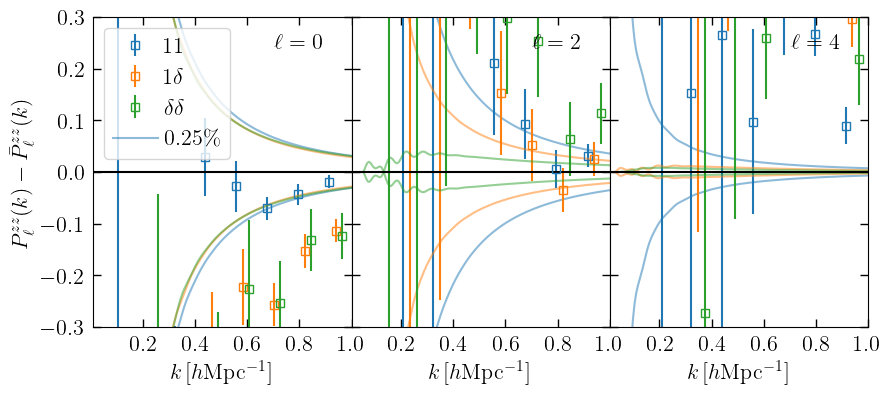

In [466]:
p0table = lptobj_4xs.p0ktable
p2table = lptobj_4xs.p2ktable
p4table = lptobj_4xs.p4ktable

pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
pktable[:,0,:] = p0table
pktable[:,1,:] = p2table
pktable[:,2,:] = p4table

km = (kout[1:] + kout[:-1])/2
pktable = pspline(kin) #* kin**2
#pk_zb_conv = np.stack([np.dot(window, pktable[i,:,:nki].reshape(-1)).reshape(3,-1) for i in range(3)])
#pk_zb_eval = pspline((kout[1:] + kout[:-1])/2)
#nmodes[:nko]*norm_out[0*nko:1*nko]

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ncut = 160
rebin = 20
nstart = 2
V = 1050**3
kcut = np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin) * kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1) / np.sum(kd[nstart:ncut+nstart].reshape(-1,rebin)**3, axis=-1)
dkb=0.025
lines = []
deltas = []
delta_stds = []
for ell in range(3):
    for sidx in range(3):
        fudge=1
        idx = pktable[sidx,ell,:]==pktable[sidx,ell,:]
        pspline_kc1 = interp1d(kin[idx], pktable[sidx,ell,idx], kind='linear', fill_value='extrapolate', axis=-1)
        pk_zenbu_uc = pspline_kc1(k)
        pk_zenbu = pell_convs_4xs[sidx,ell,nstart:ncut+nstart]

#        pk_zenbu = pspline(k)[sidx,ell,nstart:ncut+nstart]
        dlist = []
        for i in range(len(pell_ij_poles_list)):
            delta_i = (pell_ij_poles_list[i][sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]#* kd[nstart:ncut+nstart]**3
            delta_i = np.sum(delta_i[:].reshape(ncut//rebin,rebin), axis=-1) / np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
            dlist.append(delta_i)
        
        delta_std = np.std(np.stack(dlist), axis=0) / len(dlist) #/ np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        #delta_std = np.sqrt(np.diag(covs[sidx])[ell*nkcov:(ell+1)*nkcov][:len(kcut)])/len(dlist)
        delta_stds.append(delta_std)
        delta = (pell_ij_poles[sidx,ell,nstart:ncut+nstart]-pk_zenbu) * nmodes[nstart:ncut+nstart]
        delta = np.sum(delta[:].reshape(ncut//rebin,rebin), axis=-1)/np.sum(nmodes[nstart:ncut+nstart].reshape(-1,rebin), axis=-1)
        deltas.append(delta)
        l = ax[ell].errorbar(kcut+dkb*sidx, delta, delta_std, marker='s', ls='', markerfacecolor="None",)
        
        l2 = ax[ell].plot(k+dkb*sidx, -0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        ax[ell].plot(k+dkb*sidx, 0.0025*pk_zenbu_uc, color='C{}'.format(sidx), alpha=0.5)
        if (ell==0):
            lines.append(l)
            if sidx==0:
                ll = l2
#    plt.semilogx(k, (pell_ij_poles[sidx,ell,:]-1050**3/(1400**3)/2)/pk_zenbu-1)
    ax[ell].hlines(0, k[0], k[-1], color='k')
    ax[ell].set_xlabel(r'$k\,[h\rm Mpc^{-1}]$')
    ax[ell].text(0.7, 0.9, r'$\ell={}$'.format(ell*2), transform=ax[ell].transAxes)
    
lines.append(ll[0])
ax[0].legend(lines, [r'$11$', r'$1\delta$', r'$\delta\delta$', r'$0.25\%$'], loc='upper left')
ax[0].set_ylabel(r'$P^{zz}_{\ell}(k) - \bar{P}^{zz}_{\ell}(k)$')
plt.xlim([0.01,1])
ax[0].set_ylim([-0.3, 0.3])
#ax[1].set_ylim([-1, 1])
#ax[2].set_ylim([-1, 1])
ax[0].set_xticks(np.linspace(0.2, 1.0, 5))

f.set_figheight(4)
f.subplots_adjust(wspace=0)
#ax[0].tick_params(which='minor', length=4)
#plt.savefig('zenbu_comp_2xsmooth.pdf', dpi=100, bbox_inches='tight')
